# Minimal Code Example: Symbolic JULES Model
## Python/Jupyter Setup (No edits)
Jupyter Settings:

Notes:
2020-02-18: copied from jon_yib/createModel3.py


In [1]:
# load HTML to adjust jupyter settings
from IPython.display import HTML

# adjust jupyter display to full screen width
display(HTML("<style>.container { width:100% !important; }</style>"))

# set auto reload for notebook
%load_ext autoreload
%autoreload 2

In [2]:
# Packages for symbolic code:
from sympy import Symbol, Function
from ComputabilityGraphs.CMTVS import CMTVS
from sympy import Symbol, Function, diag, ImmutableMatrix
from pathlib import Path
from copy import copy, deepcopy
from functools import reduce
from typing import Callable
from pprint import pprint
import json
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
#from CompartmentalSystems.TimeStepIterator import TimeStepIterator2
#import CompartmentalSystems.helpers_reservoir as hr

from bgc_md2.helper import module_computers
from bgc_md2.resolve.mvars import (
    InFluxesBySymbol,
    OutFluxesBySymbol,
    InternalFluxesBySymbol,
    TimeSymbol,
    StateVariableTuple,
)
import bgc_md2.resolve.computers as bgc_c

import bgc_md2.resolve.computers as bgc_c
import bgc_md2.display_helpers as dh
import bgc_md2.helper as h
from collections import namedtuple

# Other packages
import sys

sys.path.insert(0, '..')  # necessary to import general_helpers
#from general_helpers import (
#    download_TRENDY_output,
#    day_2_month_index,
#    month_2_day_index,
#    make_B_u_funcs_2,
#    monthly_to_yearly,
#    plot_solutions
#)
import general_helpers as gh
import model_specific_helpers_2 as msh
import test_helpers as th
from source import mvs

HTML(value='<style>.container { width:100% !important; }</style>')

## Model Figure and Matrix Equations
#### Model Figure:

{InputTuple,CompartmentalMatrix}
{InFluxesBySymbol,InputTuple,InternalFluxesBySymbol,SmoothReservoirModel,CompartmentalMatrix,OutFluxesBySymbol}
{InFluxesBySymbol,InputTuple,InternalFluxesBySymbol,SmoothReservoirModel,CompartmentalMatrix,OutFluxesBySymbol}


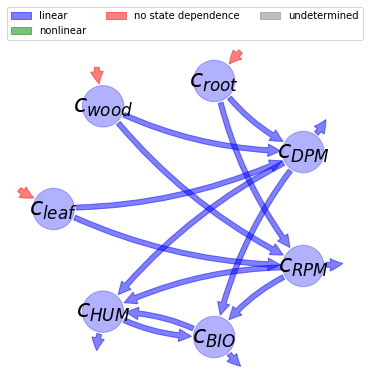

In [3]:
h.compartmental_graph(mvs)

In [4]:
mvs.get_CompartmentalMatrix()

Matrix([
[-r_c_leaf_2_c_DPM - r_c_leaf_2_c_RPM,                                    0,                                    0,                                                       0,                                                       0,                                     0,                                     0],
[                                   0, -r_c_wood_2_c_DPM - r_c_wood_2_c_RPM,                                    0,                                                       0,                                                       0,                                     0,                                     0],
[                                   0,                                    0, -r_c_root_2_c_DPM - r_c_root_2_c_RPM,                                                       0,                                                       0,                                     0,                                     0],
[                    r_c_leaf_2_c_DPM,                     r_c_wood

In [5]:
mvs.get_InternalFluxesBySymbol()

frozendict({(c_leaf, c_DPM): c_leaf*r_c_leaf_2_c_DPM, (c_leaf, c_RPM): c_leaf*r_c_leaf_2_c_RPM, (c_wood, c_DPM): c_wood*r_c_wood_2_c_DPM, (c_wood, c_RPM): c_wood*r_c_wood_2_c_RPM, (c_root, c_DPM): c_root*r_c_root_2_c_DPM, (c_root, c_RPM): c_root*r_c_root_2_c_RPM, (c_DPM, c_BIO): c_DPM*r_c_DPM_2_c_BIO*xi(t), (c_DPM, c_HUM): c_DPM*r_c_DPM_2_c_HUM*xi(t), (c_RPM, c_BIO): c_RPM*r_c_RPM_2_c_BIO*xi(t), (c_RPM, c_HUM): c_RPM*r_c_RPM_2_c_HUM*xi(t), (c_BIO, c_HUM): c_BIO*r_c_BIO_2_c_HUM*xi(t), (c_HUM, c_BIO): c_HUM*r_c_HUM_2_c_BIO*xi(t)})

## Download Data
#### TRENDY Data
Make sure you have a config.json file in your model folder: <br>
Config.jon file contents: `{"username": "trendy-v9", "password": "gcb-2020", "dataPath": "/path/to/data/folder"}`

In [6]:
import json

# Read username, password, dataPath from config.json file
with Path('config.json').open(mode='r') as f:
    conf_dict = json.load(f)
    

In [7]:
#msh.download_my_TRENDY_output(conf_dict)
ta=th.make_test_args(conf_dict,msh,mvs)

reading  cVeg , size is  (3840, 144, 192)
reading  cSoil , size is  (3840, 144, 192)
reading  rh , size is  (3840, 144, 192)
reading  fVegSoil , size is  (3840, 144, 192)
reading  npp_nlim , size is  (3840, 144, 192)
reading  mrsos , size is  (3840, 144, 192)
reading  tsl , size is  (3840, 4, 144, 192)
converted size is  (3840, 144, 192)
reading  landCoverFrac , size is  (3840, 17, 144, 192)
creating a zero arry, shape is  (3840, 144, 192)


## Connect Data and Symbols (Must Edit)
Define function to subset netCDF files and link to data symbols:

In [8]:
## call function to link symbols and data
svs, dvs = msh.get_global_mean_vars(dataPath=Path(conf_dict["dataPath"]))

reading  cVeg , size is  (3840, 144, 192)
reading  cSoil , size is  (3840, 144, 192)
reading  rh , size is  (3840, 144, 192)
reading  fVegSoil , size is  (3840, 144, 192)
reading  npp_nlim , size is  (3840, 144, 192)
reading  mrsos , size is  (3840, 144, 192)
reading  tsl , size is  (3840, 4, 144, 192)
converted size is  (3840, 144, 192)
reading  landCoverFrac , size is  (3840, 17, 144, 192)
creating a zero arry, shape is  (3840, 144, 192)


In [9]:
Path(conf_dict["dataPath"])

WindowsPath('E:/YZ/2_Side_projects/CMIP6_WG/TRENDYv9/JULES-ES-1.0/S2')

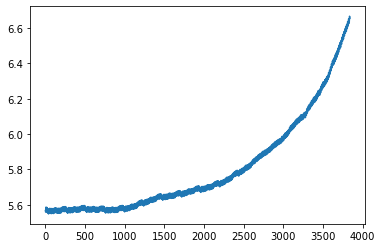

In [10]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms


fig, ax = plt.subplots() #[(12*10-1):12*30]
plt.plot(list(range(0, 12*320)), np.array(svs.cVeg), label = "observation")

## Create Symbols for $\xi$, $K$, and $A$ (No Edits)
Setup Yiqi matrix format:

In [11]:
par_dict = {
    Symbol(k): v
    for k, v in {
        'beta_leaf': 0.35,
        'beta_wood': 0.30,
        # 'r_c_leaf_rh': 0,
        # 'r_c_wood_rh': 0,
        # 'r_c_root_rh': 0,
        'r_c_DPM_rh':0.0218855218855219,
        'r_c_RPM_rh':0.000866666666666667,
        'r_c_BIO_rh':0.00174841269841270,
        'r_c_HUM_rh':5.87450980392157e-5,
        'r_c_leaf_2_c_DPM':0.000152777777777778,
        'r_c_leaf_2_c_RPM':0.000541666666666667,
        'r_c_wood_2_c_DPM':2.00364298724954e-5,
        'r_c_wood_2_c_RPM':7.10382513661202e-5,
        'r_c_root_2_c_DPM':0.000152777777777778,
        'r_c_root_2_c_RPM':0.000541666666666667,
        'r_c_DPM_2_c_BIO':0.00283950617283951,
        'r_c_DPM_2_c_HUM':0.00333333333333333,
        'r_c_RPM_2_c_BIO':0.000112444444444444,
        'r_c_RPM_2_c_HUM':0.000132000000000000,
        'r_c_BIO_2_c_HUM':0.000235714285714286,
        'r_c_HUM_2_c_BIO':6.61437908496732e-6
    }.items()
}
#par_dict


In [12]:
svs_0 = msh.Observables(*map(lambda v: v[0], svs))
svs_0.cSoil

13.094328341221093

## Assign Initial Values for the iterator

In [13]:
# Create vector of initial pool values
svs_0 = msh.Observables(*map(lambda v: v[0], svs))

StartVector = msh.make_StartVector(mvs)
StartVector._fields

('c_leaf',
 'c_wood',
 'c_root',
 'c_DPM',
 'c_RPM',
 'c_BIO',
 'c_HUM',
 'rh',
 'fVegSoil')

In [14]:
# Assign values to initial pools using InitialPools named tuple
V_init = StartVector(
    c_leaf=svs_0.cVeg * 0.12,  # set inital pool values to svs values
    c_root=svs_0.cVeg * 0.12,  # you can set numerical values here directly as well
    c_wood=svs_0.cVeg * 0.76,
    c_DPM=svs_0.cSoil * 0.0025,
    c_RPM=svs_0.cSoil * 0.248,
    c_BIO=svs_0.cSoil * 0.022,
    c_HUM=svs_0.cSoil * 0.7275,
    rh=svs_0.rh,
    fVegSoil=svs_0.fVegSoil
    # f_veg2soil=svs_0.f_veg2soil# add the fraction
)
V_init._asdict()  # print - everything should have a numeric value

{'c_leaf': 0.6681068436750298,
 'c_wood': 4.2313433432751895,
 'c_root': 0.6681068436750298,
 'c_DPM': 0.03273582085305273,
 'c_RPM': 3.247393428622831,
 'c_BIO': 0.28807522350686404,
 'c_HUM': 9.526123868238345,
 'rh': 0.0007993723269219927,
 'fVegSoil': 0.0007947221986544298}

## Define Forward Model
#### Create constants for forward sim:

In [15]:
cpa = msh.Constants(
    # use Constants namedtuple to define constant values #Define the constant values of parameters NOT affected by data assimilation
    npp_0=dvs.npp[0],
    rh_0=svs_0.rh,
    c_veg_0=svs_0.cVeg,
    c_soil_0=svs_0.cSoil,
    fVegSoil_0=svs_0.fVegSoil,  # add the fraction
    nyears=320
)
cpa._asdict()  # print - everything should have a numeric value

{'npp_0': 0.000676576176161148,
 'rh_0': 0.0007993723269219927,
 'c_veg_0': 5.567557030625249,
 'c_soil_0': 13.094328341221093,
 'fVegSoil_0': 0.0007947221986544298,
 'nyears': 320}

#### Create list of parameters to be optimized during data assimilation:

In [16]:
epa_0 = msh.EstimatedParameters(
    **{
        'c_leaf_0': svs_0.cVeg * 0.12,  # set inital pool values to svs values
        'c_wood_0': svs_0.cVeg * 0.76,  # you can set numerical values here directly as well
        'c_DPM_0': svs_0.cSoil * 0.0025,  # set according to QY's single site results: 0.0025 DPM, 0.22 RPM, 0.02 BIO, 0.7575 HUM
        'c_RPM_0': svs_0.cSoil * 0.248,
        'c_BIO_0': svs_0.cSoil * 0.022
    },
    **{
        'beta_leaf': 0.35,
        'beta_wood': 0.3,
        'Mw': 0.1,
        'Ms': np.max(dvs.mrsos) + 500, #, may need add a condition here ## ASK MARKUS
        'Topt': 18.32,
        'Tcons': 47.91,
        # 'r_c_leaf_rh': 0,
        # 'r_c_wood_rh': 0,
        # 'r_c_root_rh': 0,
        'r_c_DPM_rh':0.0218855218855219,
        'r_c_RPM_rh':0.000866666666666667,
        'r_c_BIO_rh':0.00174841269841270,
        'r_c_HUM_rh':5.87450980392157e-5,
        'r_c_leaf_2_c_DPM':0.000152777777777778,
        'r_c_leaf_2_c_RPM':0.000541666666666667,
        'r_c_wood_2_c_DPM':2.00364298724954e-5,
        'r_c_wood_2_c_RPM':7.10382513661202e-5,
        'r_c_root_2_c_DPM':0.000152777777777778,
        'r_c_root_2_c_RPM':0.000541666666666667,
        'r_c_DPM_2_c_BIO':0.00283950617283951,
        'r_c_DPM_2_c_HUM':0.00333333333333333,
        'r_c_RPM_2_c_BIO':0.000112444444444444,
        'r_c_RPM_2_c_HUM':0.000132000000000000,
        'r_c_BIO_2_c_HUM':0.000235714285714286,
        'r_c_HUM_2_c_BIO':6.61437908496732e-6
    }
    # **{str(key): value for key,value in  par_dict.items() if}
)

#### Create forward model function:

In [17]:
func_dict = msh.make_func_dict(mvs, dvs, cpa, epa_0)

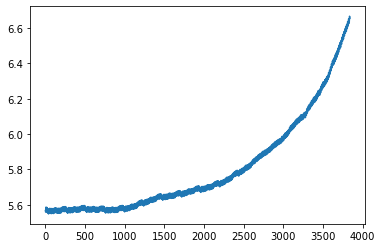

In [18]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms


fig, ax = plt.subplots() #[(12*10-1):12*30]
plt.plot(list(range(0, 12*320)), np.array(svs.cVeg), label = "observation")

## Forward Model Run
#### Run model forward:

In [23]:
epa_0 = ta.epa_0
cpa = ta.cpa
dvs = ta.dvs
mvs = ta.mvs
svs = ta.svs
param2res = msh.make_param2res_sym(mvs, cpa, dvs)  # Define forward model
obs_simu = param2res(epa_0)  # Run forward model from initial conditions

obs_simu

svs_cut = msh.Observables(
    cVeg = svs.cVeg[:cpa.nyears * 12],
    cSoil = svs.cSoil[:cpa.nyears * 12],
    rh = svs.rh[:cpa.nyears * 12],
    fVegSoil = svs.fVegSoil[:cpa.nyears*12]
)
svs_cut.rh
cost_func = msh.make_weighted_cost_func(svs_cut)
cost_func(obs_simu)

cVeg J1 =  0.005888369655864202 c Soil J2 =  0.06428099207637922 rh J3 =  2.3553421279231337


2.425511489655377

#### Create array of yearly observation data:

In [20]:
#fig = plt.figure()
#gh.plot_observations_vs_simulations(fig, svs_cut, obs_simu)
#fig.savefig("test.pdf")

#### Plot data-model fit:

0.000454930810935728

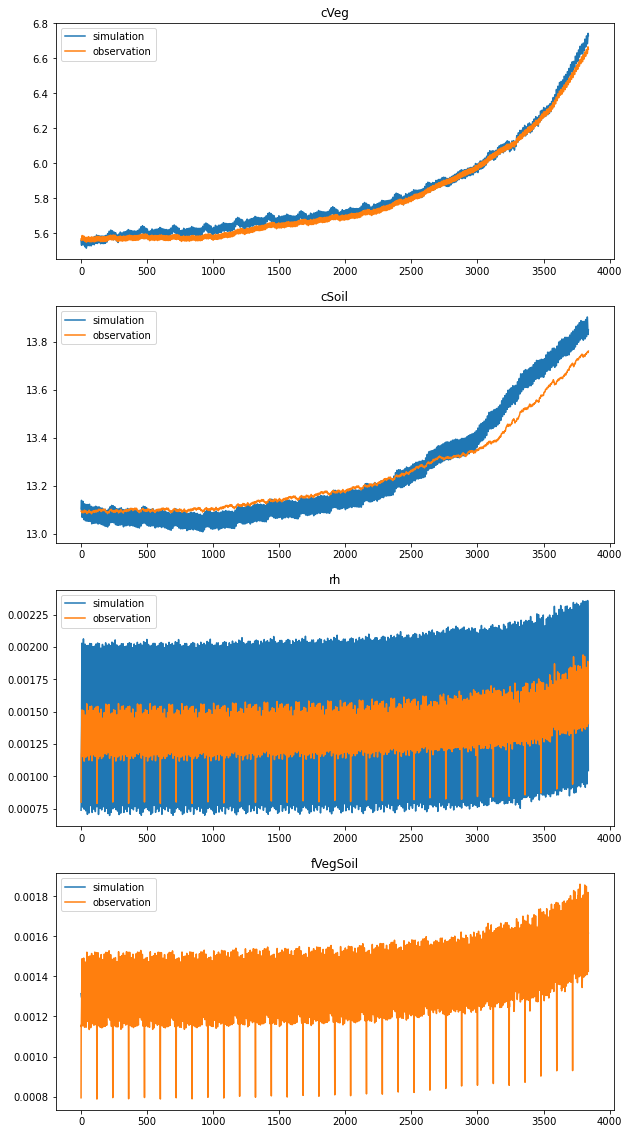

In [21]:
# Plot simulation output for observables
n_plots = len(svs_cut)
fig = plt.figure(figsize=(10, n_plots * 5))
axs = fig.subplots(n_plots)
for i, name in enumerate(msh.Observables._fields):
    var = svs_cut[i]
    var_simu = obs_simu[i]
    axs[i].plot(range(len(var_simu)), var_simu, label="simulation")
    axs[i].plot(range(len(var)), var, label='observation')
    axs[i].legend()
    axs[i].set_title(name)

sum((np.array(svs.rh) - np.array(obs_simu.rh))**2)

## Data Assimilation
#### Define parameter min/max values:

#### Conduct data assimilation:

In [24]:

print("Starting data assimilation...")
# Autostep MCMC: with uniform proposer modifying its step every 100 iterations depending on acceptance rate
C_autostep, J_autostep = gh.autostep_mcmc(
    initial_parameters=ta.epa_0,
    filter_func=gh.make_param_filter_func_2(ta.epa_max, ta.epa_min,["beta_leaf","beta_wood"]),
    param2res=msh.make_param2res_sym(mvs, cpa, dvs),
    costfunction=msh.make_weighted_cost_func(svs),
    nsimu=5000,  # for testing and tuning mcmc
    c_max=np.array(ta.epa_max),
    c_min=np.array(ta.epa_min),
    acceptance_rate=15,  # default value | target acceptance rate in %
    chunk_size=100,  # default value | number of iterations to calculate current acceptance ratio and update step size
    D_init=1,  # default value | increase value to reduce initial step size
    K = 1 #2  # default value | increase value to reduce acceptance of higher cost functions
)
print("Data assimilation finished!")

Starting data assimilation...
cVeg J1 =  0.005888369655864202 c Soil J2 =  0.06428099207637922 rh J3 =  2.3553421279231337
First_iteration done after 3.45s
Status update every 10 iterations:
cVeg J1 =  85.16965373431854 c Soil J2 =  779.4047270140662 rh J3 =  8.13854700430328
 
               #(upgraded): 0  | D value: 1 | overall acceptance rate: 0%  
               progress: 00000/05000 |                                                  | 00%
               time elapsed: 00:03
               overall min cost: 2.43 achieved at 0 iteration | last accepted cost: 2.43 
               cVeg J1 =  115.65358071552919 c Soil J2 =  731.648248416453 rh J3 =  4.794766065022647
cVeg J1 =  2.484734485317581 c Soil J2 =  613.0623414040114 rh J3 =  2.881300087473483
cVeg J1 =  19.314369106615352 c Soil J2 =  1021.8438395007838 rh J3 =  8.814516118090713
cVeg J1 =  77.88102337276392 c Soil J2 =  811.970226546157 rh J3 =  4.222361901482189
cVeg J1 =  86.68427451597502 c Soil J2 =  1612.0526913628078 r

cVeg J1 =  99.81676495497894 c Soil J2 =  1356.2533520662425 rh J3 =  6.087381891275755
cVeg J1 =  28.38226385869362 c Soil J2 =  396.75477038224926 rh J3 =  3.6040188988178543
cVeg J1 =  80.35238546825921 c Soil J2 =  253.2819946439725 rh J3 =  2.653724512188178
cVeg J1 =  68.85800915889256 c Soil J2 =  265.7101907828659 rh J3 =  2.2883364585927377
cVeg J1 =  2.797411240959199 c Soil J2 =  1416.691039368469 rh J3 =  13.044430676787535
 
               #(upgraded): 0  | D value: 1 | overall acceptance rate: 0%  
               progress: 00070/05000 |                                                 | 01%
               time elapsed: 04:17
               overall min cost: 2.43 achieved at 0 iteration | last accepted cost: 2.43 
               cVeg J1 =  37.7160876662922 c Soil J2 =  511.74902485529253 rh J3 =  4.973633608722914
cVeg J1 =  107.60421847121802 c Soil J2 =  760.0944722411014 rh J3 =  4.310503154228006
cVeg J1 =  0.23987170527632848 c Soil J2 =  745.8757805050674 rh J3 =  4.5

cVeg J1 =  1213.1976918967134 c Soil J2 =  65.49982645260935 rh J3 =  2.3229407011882532
cVeg J1 =  24.941488214260072 c Soil J2 =  280.7406356620754 rh J3 =  2.5689601625499714
cVeg J1 =  2.650980028227597 c Soil J2 =  3382.5160792059837 rh J3 =  2.3490100448079545
cVeg J1 =  180.15956627408906 c Soil J2 =  12.055107642947005 rh J3 =  2.02543081718943
cVeg J1 =  48.312792503196334 c Soil J2 =  73.05625923829417 rh J3 =  2.322657120759367
cVeg J1 =  26.027512771785993 c Soil J2 =  232.26886152459662 rh J3 =  2.5018715411906904
cVeg J1 =  7.482610244496323 c Soil J2 =  16.893445989444036 rh J3 =  2.565138267553432
 
               #(upgraded): 0  | D value: 3.873 | overall acceptance rate: 0%  
               progress: 00140/05000 |#                                                | 02%
               time elapsed: 08:25
               overall min cost: 2.43 achieved at 0 iteration | last accepted cost: 2.43 
               cVeg J1 =  0.8660363855554779 c Soil J2 =  333.10771079118535 rh

cVeg J1 =  0.8977963204654076 c Soil J2 =  4.801846413370617 rh J3 =  2.439727739467116
cVeg J1 =  0.19938311882636386 c Soil J2 =  14.505871311084165 rh J3 =  2.446056308011101
cVeg J1 =  2.637909164074819 c Soil J2 =  11.701224707142593 rh J3 =  2.470100739142476
cVeg J1 =  0.1001662440456571 c Soil J2 =  13.071397562201993 rh J3 =  2.355989497516596
cVeg J1 =  1.257346418551717 c Soil J2 =  15.879975096883442 rh J3 =  2.4546347309833694
cVeg J1 =  1.493241333612655 c Soil J2 =  8.155602596358785 rh J3 =  2.356581120250197
cVeg J1 =  0.32278154035517437 c Soil J2 =  67.33360648778749 rh J3 =  2.220515600191862
cVeg J1 =  3.33767444357747 c Soil J2 =  2.555769074660421 rh J3 =  2.4185162604322357
cVeg J1 =  2.7694264209131716 c Soil J2 =  17.240254551483876 rh J3 =  2.315171105573792
 
               #(upgraded): 0  | D value: 15.0 | overall acceptance rate: 0%  
               progress: 00210/05000 |##                                               | 04%
               time elapsed: 1

               cVeg J1 =  1.6315622721057887 c Soil J2 =  20.5537084139208 rh J3 =  2.298442831528648
cVeg J1 =  4.690351225565691 c Soil J2 =  3.292785937344538 rh J3 =  2.354402152644744
cVeg J1 =  4.833054176620435 c Soil J2 =  47.025844726206095 rh J3 =  2.247674809677266
cVeg J1 =  0.44497033466309655 c Soil J2 =  16.629702940487793 rh J3 =  2.3434460148995457
cVeg J1 =  0.306020748557903 c Soil J2 =  8.942024089683358 rh J3 =  2.291032837562358
cVeg J1 =  1.0584018260027006 c Soil J2 =  57.60103033786653 rh J3 =  2.4482075721145216
cVeg J1 =  0.9931151164576963 c Soil J2 =  39.593490552477114 rh J3 =  2.2855117631924324
cVeg J1 =  0.5343484083506788 c Soil J2 =  0.46887182325682847 rh J3 =  2.3743891511769046
cVeg J1 =  1.0111883252167406 c Soil J2 =  7.935941367168608 rh J3 =  2.3883756853909435
cVeg J1 =  0.5553197649880863 c Soil J2 =  4.746230850626662 rh J3 =  2.4396655368227314
 
               #(upgraded): 0  | D value: 15.0 | overall acceptance rate: 0%  
               p

               cVeg J1 =  0.27060416859581565 c Soil J2 =  0.5990817218271011 rh J3 =  2.383329121687642
cVeg J1 =  0.010493069433489087 c Soil J2 =  0.6368596152102319 rh J3 =  2.3812439478056056
cVeg J1 =  0.07927064866300833 c Soil J2 =  3.516322386038275 rh J3 =  2.395308095550886
cVeg J1 =  0.09229403182814157 c Soil J2 =  2.6172692709895347 rh J3 =  2.3395309775483937
cVeg J1 =  0.18818551330545402 c Soil J2 =  1.9988988069927358 rh J3 =  2.337032111794427
cVeg J1 =  0.154542395708985 c Soil J2 =  0.053012464397821424 rh J3 =  2.3812593950157477
cVeg J1 =  0.2922237800362622 c Soil J2 =  1.0627318703978947 rh J3 =  2.3655548354187097
cVeg J1 =  0.11374077630863835 c Soil J2 =  0.2739822465288613 rh J3 =  2.341457361302582
cVeg J1 =  0.0033414476688785767 c Soil J2 =  0.22672380998712532 rh J3 =  2.35260222290654
cVeg J1 =  0.0061157215916118335 c Soil J2 =  5.30212388377566 rh J3 =  2.3354665383555187
 
               #(upgraded): 1  | D value: 58.095 | overall acceptance rate: 0

cVeg J1 =  0.01999040089861094 c Soil J2 =  0.12681745486518475 rh J3 =  2.3626895788977866
 
               #(upgraded): 3  | D value: 225.0 | overall acceptance rate: 0%  
               progress: 00410/05000 |####                                             | 08%
               time elapsed: 23:57
               overall min cost: 2.41 achieved at 301 iteration | last accepted cost: 2.46 
               cVeg J1 =  0.04200440156601708 c Soil J2 =  0.05189720740388214 rh J3 =  2.364880242963735
cVeg J1 =  0.024875940250271414 c Soil J2 =  0.14290034302326748 rh J3 =  2.3699473338378976
cVeg J1 =  0.05765368742380479 c Soil J2 =  0.04944920372723502 rh J3 =  2.3629299104688655
cVeg J1 =  0.028679604615355854 c Soil J2 =  0.06497423137959175 rh J3 =  2.3594239550448926
cVeg J1 =  0.0675476146482797 c Soil J2 =  0.16346344500962892 rh J3 =  2.36416917339293
cVeg J1 =  0.018860765048091074 c Soil J2 =  0.07732710365421638 rh J3 =  2.366794747661487
cVeg J1 =  0.004038367337392042 c Soil J2

cVeg J1 =  0.006523195050666752 c Soil J2 =  0.1380752540526937 rh J3 =  2.362867517964508
cVeg J1 =  0.04114833221265831 c Soil J2 =  0.5233791220672321 rh J3 =  2.381323330821498
cVeg J1 =  0.0046552802644001575 c Soil J2 =  0.058027093977743055 rh J3 =  2.3658123683493417
cVeg J1 =  0.0029751048901183338 c Soil J2 =  0.053801043545062995 rh J3 =  2.3639105365261535
cVeg J1 =  0.023533745725787023 c Soil J2 =  0.058862885197654216 rh J3 =  2.3593716004401766
cVeg J1 =  0.014046384352108887 c Soil J2 =  0.06752016181844653 rh J3 =  2.3613337512045787
 
               #(upgraded): 30  | D value: 225.0 | overall acceptance rate: 6%  
               progress: 00480/05000 |####                                             | 09%
               time elapsed: 27:59
               overall min cost: 2.41 achieved at 301 iteration | last accepted cost: 2.44 
               cVeg J1 =  0.002665860524664016 c Soil J2 =  0.050258089776431196 rh J3 =  2.3643909682010573
cVeg J1 =  0.01468399822686443

               cVeg J1 =  0.0033829874643138145 c Soil J2 =  0.12280295642596369 rh J3 =  2.3539697754193565
cVeg J1 =  0.009666425431525065 c Soil J2 =  0.5615569079818689 rh J3 =  2.368909906501874
cVeg J1 =  0.027301944083950314 c Soil J2 =  0.08578138930761783 rh J3 =  2.3653900865947572
cVeg J1 =  0.004473875904794003 c Soil J2 =  0.04394832717910199 rh J3 =  2.359464630081297
cVeg J1 =  0.009124430276770287 c Soil J2 =  0.16543179354155965 rh J3 =  2.3682356431794136
cVeg J1 =  0.030975517065749265 c Soil J2 =  0.06815234378229723 rh J3 =  2.3571279253220347
cVeg J1 =  0.025223599989799544 c Soil J2 =  1.7034395849533222 rh J3 =  2.379424946627962
cVeg J1 =  0.0047733296418583735 c Soil J2 =  0.19041534981435887 rh J3 =  2.363442333070637
cVeg J1 =  0.004875507447338968 c Soil J2 =  0.055990410834724585 rh J3 =  2.3537684769032405
cVeg J1 =  0.016949255853622384 c Soil J2 =  0.08892851669772425 rh J3 =  2.349164743642919
 
               #(upgraded): 41  | D value: 149.448 | over

cVeg J1 =  0.02326756586656529 c Soil J2 =  0.11847806926031167 rh J3 =  2.3461887943505113
cVeg J1 =  0.019390697063222915 c Soil J2 =  0.4630535540758187 rh J3 =  2.361605769467688
 
               #(upgraded): 51  | D value: 149.448 | overall acceptance rate: 8%  
               progress: 00610/05000 |######                                           | 12%
               time elapsed: 35:28
               overall min cost: 2.41 achieved at 595 iteration | last accepted cost: 2.43 
               cVeg J1 =  0.04720774480557867 c Soil J2 =  0.7368372098636154 rh J3 =  2.33847772598707
cVeg J1 =  0.021474004311383316 c Soil J2 =  0.05893040992238329 rh J3 =  2.352474872584331
cVeg J1 =  0.02684043952313554 c Soil J2 =  0.11754321500177875 rh J3 =  2.3568089637254364
cVeg J1 =  0.040879521380105255 c Soil J2 =  0.06600646118670264 rh J3 =  2.35093161852425
cVeg J1 =  0.05251530621734489 c Soil J2 =  0.08188831220374994 rh J3 =  2.349616299478842
cVeg J1 =  0.07383809462068021 c Soil J2 =

cVeg J1 =  0.07659900503670629 c Soil J2 =  2.251304870058244 rh J3 =  2.374660607799154
cVeg J1 =  0.07440539288814048 c Soil J2 =  0.2499952655939316 rh J3 =  2.3463831578184644
cVeg J1 =  0.0033159679481142125 c Soil J2 =  0.8721534302088186 rh J3 =  2.3731596922519422
cVeg J1 =  0.007806259414008819 c Soil J2 =  0.192439375705837 rh J3 =  2.3606596633009627
cVeg J1 =  0.03748458794092023 c Soil J2 =  0.06538866878294544 rh J3 =  2.358704688880954
cVeg J1 =  0.006029166110364107 c Soil J2 =  0.16757982164065152 rh J3 =  2.366321844926093
cVeg J1 =  0.012097836611471239 c Soil J2 =  0.831955352462766 rh J3 =  2.347194386397674
 
               #(upgraded): 66  | D value: 149.448 | overall acceptance rate: 9%  
               progress: 00680/05000 |######                                           | 13%
               time elapsed: 39:30
               overall min cost: 2.4 achieved at 659 iteration | last accepted cost: 2.46 
               cVeg J1 =  0.004013752906066352 c Soil J2 = 

               cVeg J1 =  0.0614743078421318 c Soil J2 =  0.07506030503220208 rh J3 =  2.3674784426343387
cVeg J1 =  0.007810102563792176 c Soil J2 =  0.13204803655506533 rh J3 =  2.367701002557659
cVeg J1 =  0.01638564084035189 c Soil J2 =  0.5512223428180536 rh J3 =  2.3755560662705273
cVeg J1 =  0.04709381053381133 c Soil J2 =  0.2391757183689588 rh J3 =  2.37447072771815
cVeg J1 =  0.01785539340372965 c Soil J2 =  0.44563067778075444 rh J3 =  2.3735965344476555
cVeg J1 =  0.003083136023566875 c Soil J2 =  0.32280842628241296 rh J3 =  2.3689406865438705
cVeg J1 =  0.012369899430928913 c Soil J2 =  0.39016486375058423 rh J3 =  2.3715300440917666
cVeg J1 =  0.0045476276790951745 c Soil J2 =  0.3650227912683531 rh J3 =  2.3753393591464587
cVeg J1 =  0.0033635823662873715 c Soil J2 =  0.5151063158902527 rh J3 =  2.37380806531525
cVeg J1 =  0.0024409609090187056 c Soil J2 =  0.11928978357993755 rh J3 =  2.372999987083853
 
               #(upgraded): 77  | D value: 123.402 | overall acce

cVeg J1 =  0.039542646091505394 c Soil J2 =  0.17120381208558963 rh J3 =  2.356430022585262
 
               #(upgraded): 88  | D value: 127.733 | overall acceptance rate: 10%  
               progress: 00810/05000 |########                                         | 16%
               time elapsed: 46:58
               overall min cost: 2.4 achieved at 659 iteration | last accepted cost: 2.44 
               cVeg J1 =  0.030082895206794157 c Soil J2 =  0.27276751723140946 rh J3 =  2.370586631806751
cVeg J1 =  0.02078606144081627 c Soil J2 =  0.3686329783844821 rh J3 =  2.3592524956055847
cVeg J1 =  0.005440979704633002 c Soil J2 =  1.0760629307744243 rh J3 =  2.380247625100338
cVeg J1 =  0.07862708105673545 c Soil J2 =  0.17329148421676033 rh J3 =  2.355326242238435
cVeg J1 =  0.03347417494920957 c Soil J2 =  0.37117447468818004 rh J3 =  2.3699455820874444
cVeg J1 =  0.004209607740484474 c Soil J2 =  0.30436061426356786 rh J3 =  2.3563557133894997
cVeg J1 =  0.007795087255209504 c Soil

cVeg J1 =  0.01521516260898418 c Soil J2 =  0.5763246726498366 rh J3 =  2.3771553855386647
cVeg J1 =  0.10610820010382385 c Soil J2 =  0.9738836689891869 rh J3 =  2.3707833371843834
cVeg J1 =  0.023595481875776588 c Soil J2 =  0.16416281332226249 rh J3 =  2.3539988212688097
cVeg J1 =  0.020996389808409677 c Soil J2 =  1.0892307323559685 rh J3 =  2.3457404238969026
cVeg J1 =  0.0035025141052240955 c Soil J2 =  0.42156001636038365 rh J3 =  2.3774615373852264
cVeg J1 =  0.016226087973794323 c Soil J2 =  0.17159968255202726 rh J3 =  2.3593314900929574
 
               #(upgraded): 97  | D value: 127.733 | overall acceptance rate: 11%  
               progress: 00880/05000 |########                                         | 17%
               time elapsed: 51:00
               overall min cost: 2.4 achieved at 659 iteration | last accepted cost: 2.42 
               cVeg J1 =  0.008902302607707068 c Soil J2 =  2.763701300736669 rh J3 =  2.391472712057023
cVeg J1 =  0.05352166661919471 c Soi

               cVeg J1 =  0.009794118134113529 c Soil J2 =  1.984748478120678 rh J3 =  2.338552315576761
cVeg J1 =  0.0168179021750067 c Soil J2 =  0.9492944873506346 rh J3 =  2.375479219575857
cVeg J1 =  0.03260135591528513 c Soil J2 =  0.08707258529453996 rh J3 =  2.3684142051050734
cVeg J1 =  0.10260767010596365 c Soil J2 =  1.3334233962261688 rh J3 =  2.3723638719055087
cVeg J1 =  0.027521706321492194 c Soil J2 =  0.5753765410579196 rh J3 =  2.344868726621762
cVeg J1 =  0.010847749168577977 c Soil J2 =  1.2385702171447002 rh J3 =  2.344528395198043
cVeg J1 =  0.010284594764356338 c Soil J2 =  0.3240716198312134 rh J3 =  2.3614297569409994
cVeg J1 =  0.00644533673256234 c Soil J2 =  0.046783860801269485 rh J3 =  2.3589680818850916
cVeg J1 =  0.0046290784226319034 c Soil J2 =  0.4161024760693562 rh J3 =  2.352826258142883
cVeg J1 =  0.01868125613687155 c Soil J2 =  0.16036819498711719 rh J3 =  2.36804913808005
 
               #(upgraded): 104  | D value: 123.677 | overall acceptance

cVeg J1 =  0.012273631099443448 c Soil J2 =  0.09845938750067793 rh J3 =  2.3622475662629743
cVeg J1 =  0.023066249018346138 c Soil J2 =  0.06084758171497234 rh J3 =  2.353340286095247
 
               #(upgraded): 111  | D value: 195.551 | overall acceptance rate: 10%  
               progress: 01010/05000 |##########                                       | 20%
               time elapsed: 58:29
               overall min cost: 2.4 achieved at 659 iteration | last accepted cost: 2.44 
               cVeg J1 =  0.008413713368583006 c Soil J2 =  0.25171949567475593 rh J3 =  2.350968707622854
cVeg J1 =  0.029971602336641527 c Soil J2 =  0.3423646368185192 rh J3 =  2.362723445865648
cVeg J1 =  0.03679567765130449 c Soil J2 =  0.18265003018065964 rh J3 =  2.349532489860125
cVeg J1 =  0.03922714258295844 c Soil J2 =  0.11267995998791565 rh J3 =  2.3559015329954023
cVeg J1 =  0.014811698766444698 c Soil J2 =  0.22773454118753444 rh J3 =  2.3637887890308975
cVeg J1 =  0.02167948616183453 c So

cVeg J1 =  0.015587033405669465 c Soil J2 =  0.04087254397404957 rh J3 =  2.357890310825955
cVeg J1 =  0.046397721992908494 c Soil J2 =  0.2883493099846461 rh J3 =  2.345008311272511
cVeg J1 =  0.05305339080308321 c Soil J2 =  0.8777417306312231 rh J3 =  2.367861117844869
cVeg J1 =  0.014365355800001743 c Soil J2 =  0.05104018663992202 rh J3 =  2.3578140539705243
cVeg J1 =  0.00815660891479027 c Soil J2 =  0.04529796856386773 rh J3 =  2.360464472663559
cVeg J1 =  0.014655786307148698 c Soil J2 =  0.18748624578015932 rh J3 =  2.3559124898116983
cVeg J1 =  0.030286591821993603 c Soil J2 =  0.045476209030312166 rh J3 =  2.36244813296006
 
               #(upgraded): 136  | D value: 195.551 | overall acceptance rate: 12%  
               progress: 01080/05000 |##########                                       | 21%
               time elapsed: 62:32
               overall min cost: 2.4 achieved at 659 iteration | last accepted cost: 2.44 
               cVeg J1 =  0.020182342897404174 c Soi

               cVeg J1 =  0.22214804000039964 c Soil J2 =  0.22544125557095976 rh J3 =  2.3422742418893403
cVeg J1 =  0.08222549533437838 c Soil J2 =  1.9692595430665945 rh J3 =  2.3705977500636655
cVeg J1 =  0.02793659310869007 c Soil J2 =  0.2849754362013393 rh J3 =  2.342660566965386
cVeg J1 =  0.08702094273738574 c Soil J2 =  0.03992444846882792 rh J3 =  2.3511629497784257
cVeg J1 =  0.24122244043074118 c Soil J2 =  0.05461121550860215 rh J3 =  2.3487253094518894
cVeg J1 =  0.031817622033707735 c Soil J2 =  1.1465669306153277 rh J3 =  2.3745712644426664
cVeg J1 =  0.05838956753384953 c Soil J2 =  0.06229404420349848 rh J3 =  2.3502644184720283
cVeg J1 =  0.015323284844928448 c Soil J2 =  0.10615824921049252 rh J3 =  2.3576703395081684
cVeg J1 =  0.008722681197735413 c Soil J2 =  0.09001181903453533 rh J3 =  2.362047725627289
cVeg J1 =  0.009692595027750982 c Soil J2 =  0.11793170873790455 rh J3 =  2.3631484512053573
 
               #(upgraded): 145  | D value: 136.027 | overall ac

cVeg J1 =  0.020859211090658605 c Soil J2 =  0.07612263962859267 rh J3 =  2.3475747958040794
 
               #(upgraded): 149  | D value: 186.263 | overall acceptance rate: 12%  
               progress: 01210/05000 |############                                     | 24%
               time elapsed: 70:02
               overall min cost: 2.4 achieved at 659 iteration | last accepted cost: 2.44 
               cVeg J1 =  0.0087176911567961 c Soil J2 =  0.5696273940936665 rh J3 =  2.3332311938654478
cVeg J1 =  0.029010825199433904 c Soil J2 =  0.14535340040310726 rh J3 =  2.347163263273543
cVeg J1 =  0.09358473714054463 c Soil J2 =  0.08387252123598773 rh J3 =  2.3512054531602806
cVeg J1 =  0.06278213995036105 c Soil J2 =  0.14838117219461347 rh J3 =  2.3571875002174556
cVeg J1 =  0.11640937568620269 c Soil J2 =  0.37913126093896526 rh J3 =  2.347485410580195
cVeg J1 =  0.019764043103322047 c Soil J2 =  0.09213765438841626 rh J3 =  2.347184718700001
cVeg J1 =  0.060174629713964874 c Soi

cVeg J1 =  0.007988411722970764 c Soil J2 =  0.16060941861536043 rh J3 =  2.354495219785369
cVeg J1 =  0.012045412003225568 c Soil J2 =  0.0771410538214034 rh J3 =  2.3484212274028766
cVeg J1 =  0.006171068402425043 c Soil J2 =  0.2873950925834359 rh J3 =  2.339540068326523
cVeg J1 =  0.04553127722450884 c Soil J2 =  0.31340325085924636 rh J3 =  2.3413648385453962
cVeg J1 =  0.045533185463325514 c Soil J2 =  0.3898487608315549 rh J3 =  2.3397195864007787
cVeg J1 =  0.016247398770217195 c Soil J2 =  0.06263227459621953 rh J3 =  2.349270625794566
 
               #(upgraded): 159  | D value: 186.263 | overall acceptance rate: 12%  
               progress: 01280/05000 |############                                     | 25%
               time elapsed: 74:03
               overall min cost: 2.4 achieved at 659 iteration | last accepted cost: 2.43 
               cVeg J1 =  0.04336788829382439 c Soil J2 =  0.24532087538742933 rh J3 =  2.3425095655449018
cVeg J1 =  0.011905303901000062 c So

               cVeg J1 =  0.04765012788128092 c Soil J2 =  0.06307958537762391 rh J3 =  2.3351398142505526
cVeg J1 =  0.014557816328365123 c Soil J2 =  0.3828953605610148 rh J3 =  2.348875233952345
cVeg J1 =  0.057053628324689215 c Soil J2 =  0.9773696738512002 rh J3 =  2.348714625292399
cVeg J1 =  0.08383841301359958 c Soil J2 =  0.2544988457245231 rh J3 =  2.339157565782537
cVeg J1 =  0.012539339239212612 c Soil J2 =  0.13658961403596645 rh J3 =  2.343699881866902
cVeg J1 =  0.09790309953746978 c Soil J2 =  0.23956642329067102 rh J3 =  2.3306361706071397
cVeg J1 =  0.005528690092861934 c Soil J2 =  0.12800564256461122 rh J3 =  2.332542984170046
cVeg J1 =  0.00940123588662374 c Soil J2 =  0.32220612673068916 rh J3 =  2.3340620686808973
cVeg J1 =  0.010019634214816095 c Soil J2 =  0.658524774535976 rh J3 =  2.353418694255428
cVeg J1 =  0.00911690307873269 c Soil J2 =  0.11777921000341356 rh J3 =  2.3478040491985523
 
               #(upgraded): 173  | D value: 174.963 | overall accepta

cVeg J1 =  0.006542623729481832 c Soil J2 =  0.08938334784020856 rh J3 =  2.3343859922324612
cVeg J1 =  0.013450419080005311 c Soil J2 =  1.1023489809649711 rh J3 =  2.354856699145725
 
               #(upgraded): 187  | D value: 144.471 | overall acceptance rate: 13%  
               progress: 01410/05000 |##############                                   | 28%
               time elapsed: 81:36
               overall min cost: 2.4 achieved at 1374 iteration | last accepted cost: 2.43 
               cVeg J1 =  0.028145366181508157 c Soil J2 =  0.06927324277288553 rh J3 =  2.344044151074862
cVeg J1 =  0.06358119930510021 c Soil J2 =  0.2278711527110883 rh J3 =  2.3421483265781062
cVeg J1 =  0.017967941199730945 c Soil J2 =  0.15979950087403189 rh J3 =  2.3394700767153873
cVeg J1 =  0.02025836032320135 c Soil J2 =  0.1562513134108376 rh J3 =  2.348303239357921
cVeg J1 =  0.019378117132996676 c Soil J2 =  0.1453905231652082 rh J3 =  2.3384651495736897
cVeg J1 =  0.04531294633952488 c Soi

cVeg J1 =  0.039063194144138724 c Soil J2 =  0.048555204805158236 rh J3 =  2.332026551524294
cVeg J1 =  0.08985260708290906 c Soil J2 =  0.2577341509052363 rh J3 =  2.3242330782900122
cVeg J1 =  0.006109778304628975 c Soil J2 =  1.6550864335634297 rh J3 =  2.3550616269457203
cVeg J1 =  0.010729212980534267 c Soil J2 =  1.63681185521584 rh J3 =  2.3524132583775748
cVeg J1 =  0.0524885613107343 c Soil J2 =  1.021647491484144 rh J3 =  2.3485677878565827
cVeg J1 =  0.010756956459476458 c Soil J2 =  0.05562910414819857 rh J3 =  2.33253072255829
cVeg J1 =  0.015629417620228833 c Soil J2 =  0.08478033340268701 rh J3 =  2.335395457414042
 
               #(upgraded): 200  | D value: 144.471 | overall acceptance rate: 13%  
               progress: 01480/05000 |##############                                   | 29%
               time elapsed: 85:38
               overall min cost: 2.39 achieved at 1426 iteration | last accepted cost: 2.4 
               cVeg J1 =  0.01586838753043328 c Soil J2

               cVeg J1 =  0.022530579441035467 c Soil J2 =  0.08248139590003978 rh J3 =  2.331420759984559
cVeg J1 =  0.04218738562939551 c Soil J2 =  0.7026469419460404 rh J3 =  2.3379654280457602
cVeg J1 =  0.020469263630489596 c Soil J2 =  0.06056267584349991 rh J3 =  2.3344560923291326
cVeg J1 =  0.002323691588326143 c Soil J2 =  0.12271676121123941 rh J3 =  2.336787851525008
cVeg J1 =  0.008308230894377886 c Soil J2 =  0.17061994783241405 rh J3 =  2.3301440922787306
cVeg J1 =  0.007455793098849534 c Soil J2 =  0.09909059755583313 rh J3 =  2.335827373211225
cVeg J1 =  0.06187836596918384 c Soil J2 =  0.9307545538311892 rh J3 =  2.3138656924910825
cVeg J1 =  0.013285506473500082 c Soil J2 =  2.009727938875979 rh J3 =  2.314428234532452
cVeg J1 =  0.16373137165860266 c Soil J2 =  0.27351539456486496 rh J3 =  2.332525991415009
cVeg J1 =  0.002950880535031411 c Soil J2 =  0.6956959654948887 rh J3 =  2.3452437873684553
 
               #(upgraded): 213  | D value: 135.707 | overall acce

cVeg J1 =  0.12298208549988258 c Soil J2 =  0.3186286345909828 rh J3 =  2.318160877050645
cVeg J1 =  0.060264244192319086 c Soil J2 =  0.048999346289950875 rh J3 =  2.319453415643241
 
               #(upgraded): 220  | D value: 135.707 | overall acceptance rate: 13%  
               progress: 01610/05000 |################                                 | 32%
               time elapsed: 93:09
               overall min cost: 2.39 achieved at 1535 iteration | last accepted cost: 2.43 
               cVeg J1 =  0.040272829913651984 c Soil J2 =  0.0940915190340854 rh J3 =  2.3189907373883853
cVeg J1 =  0.010278566741574856 c Soil J2 =  0.6001131420595379 rh J3 =  2.3053476171450433
cVeg J1 =  0.12797718784689566 c Soil J2 =  0.5567769140185064 rh J3 =  2.314023823727048
cVeg J1 =  0.044145875784979915 c Soil J2 =  0.31716216404118236 rh J3 =  2.3119376631566864
cVeg J1 =  0.13977547221126313 c Soil J2 =  0.5454194530353798 rh J3 =  2.335677505847861
cVeg J1 =  0.0030649671271970936 c So

cVeg J1 =  0.009924314552075696 c Soil J2 =  0.2306337969042247 rh J3 =  2.3326252557318123
cVeg J1 =  0.014089895293986762 c Soil J2 =  0.10058302695405444 rh J3 =  2.3212369949842198
cVeg J1 =  0.01297643722269443 c Soil J2 =  1.3301164381080584 rh J3 =  2.3095204869019303
cVeg J1 =  0.004631602770376048 c Soil J2 =  0.5010370853993829 rh J3 =  2.3107014322835084
cVeg J1 =  0.04930851185576883 c Soil J2 =  0.5855850010912153 rh J3 =  2.314054411458531
cVeg J1 =  0.005341638226226845 c Soil J2 =  0.06997075983802445 rh J3 =  2.323042321963067
cVeg J1 =  0.03957989100319845 c Soil J2 =  0.9399904887687702 rh J3 =  2.348504684620324
 
               #(upgraded): 233  | D value: 135.707 | overall acceptance rate: 13%  
               progress: 01680/05000 |################                                 | 33%
               time elapsed: 97:17
               overall min cost: 2.38 achieved at 1618 iteration | last accepted cost: 2.4 
               cVeg J1 =  0.031216075654771813 c Soil

               cVeg J1 =  0.02702761268907168 c Soil J2 =  0.7033099411424358 rh J3 =  2.336706280419911
cVeg J1 =  0.10098936997122836 c Soil J2 =  0.07810189716830351 rh J3 =  2.3280035215081147
cVeg J1 =  0.04102010945954202 c Soil J2 =  2.8340368767604254 rh J3 =  2.2955723630581075
cVeg J1 =  0.06147679677132231 c Soil J2 =  2.072777497259644 rh J3 =  2.2969419082932117
cVeg J1 =  0.04475687056661819 c Soil J2 =  0.31821266069272536 rh J3 =  2.3047362168183017
cVeg J1 =  0.08502112202882019 c Soil J2 =  3.1311252539860415 rh J3 =  2.2989187369452395
cVeg J1 =  0.048353193036577286 c Soil J2 =  0.4178182417185888 rh J3 =  2.3117908101268125
cVeg J1 =  0.0058077150848953474 c Soil J2 =  0.19364730534208388 rh J3 =  2.316445010894289
cVeg J1 =  0.106914468559642 c Soil J2 =  1.28605315442765 rh J3 =  2.3106232771213326
cVeg J1 =  0.003408782459713829 c Soil J2 =  0.11177723218271549 rh J3 =  2.315384714031853
 
               #(upgraded): 248  | D value: 117.526 | overall acceptance 

cVeg J1 =  0.05345771388604652 c Soil J2 =  0.10392382126679095 rh J3 =  2.3145172652668
 
               #(upgraded): 254  | D value: 117.526 | overall acceptance rate: 14%  
               progress: 01810/05000 |##################                               | 36%
               time elapsed: 104:48
               overall min cost: 2.38 achieved at 1618 iteration | last accepted cost: 2.39 
               cVeg J1 =  0.005423248305473741 c Soil J2 =  0.5519553057697009 rh J3 =  2.323611400188178
cVeg J1 =  0.034293622025806374 c Soil J2 =  0.3560192351119123 rh J3 =  2.2941741187915805
cVeg J1 =  0.09469862771091603 c Soil J2 =  0.9068677532534406 rh J3 =  2.318164753017412
cVeg J1 =  0.012754434345691542 c Soil J2 =  0.8479389787493854 rh J3 =  2.3009279664127944
cVeg J1 =  0.02322389635378474 c Soil J2 =  0.8469236753234748 rh J3 =  2.2993488881820685
cVeg J1 =  0.01068749236477455 c Soil J2 =  0.19314241510097238 rh J3 =  2.3225562664219623
cVeg J1 =  0.11483985630886669 c Soil J

cVeg J1 =  0.011079520132909729 c Soil J2 =  0.5774214335182222 rh J3 =  2.2895215815760843
cVeg J1 =  0.007131462128656449 c Soil J2 =  0.10631475266945978 rh J3 =  2.2994221945070037
cVeg J1 =  0.00833246525815983 c Soil J2 =  1.2666619972955204 rh J3 =  2.2892917286209267
cVeg J1 =  0.004337902857557562 c Soil J2 =  0.3663793375318476 rh J3 =  2.2994269011203476
cVeg J1 =  0.18737536521160486 c Soil J2 =  1.2364527869018982 rh J3 =  2.2752048669910803
cVeg J1 =  0.00912035932460469 c Soil J2 =  0.9205759898513125 rh J3 =  2.2872395881401273
 
               #(upgraded): 259  | D value: 117.526 | overall acceptance rate: 13%  
               progress: 01880/05000 |##################                               | 37%
               time elapsed: 108:50
               overall min cost: 2.38 achieved at 1618 iteration | last accepted cost: 2.39 
               cVeg J1 =  0.0831842734631739 c Soil J2 =  0.11432665392278644 rh J3 =  2.294409747476533
cVeg J1 =  0.042770950610108154 c So

               cVeg J1 =  0.04622330140907845 c Soil J2 =  0.07940243987578392 rh J3 =  2.303069937491813
cVeg J1 =  0.006046614144686842 c Soil J2 =  1.2572727445189136 rh J3 =  2.3210160861998355
cVeg J1 =  0.005411937338567341 c Soil J2 =  0.23237709815519947 rh J3 =  2.2976465891550064
cVeg J1 =  0.013922417725987337 c Soil J2 =  0.08565480947321952 rh J3 =  2.299130685256472
cVeg J1 =  0.0427235882837649 c Soil J2 =  0.7454590769684174 rh J3 =  2.3073486972339925
cVeg J1 =  0.006369068674725359 c Soil J2 =  0.17898493253452646 rh J3 =  2.297881539135394
cVeg J1 =  0.006237292283937357 c Soil J2 =  0.48395439714937505 rh J3 =  2.3108843821475817
cVeg J1 =  0.00594409943693495 c Soil J2 =  0.08025216959631631 rh J3 =  2.3000424968983033
cVeg J1 =  0.02571338532748436 c Soil J2 =  0.9881488398867374 rh J3 =  2.310242454660261
cVeg J1 =  0.04149964456734764 c Soil J2 =  0.21143295438439874 rh J3 =  2.300400655995953
 
               #(upgraded): 268  | D value: 185.824 | overall accep

cVeg J1 =  0.11206632434081887 c Soil J2 =  0.420472832065588 rh J3 =  2.3228997823187436
cVeg J1 =  0.005272053659093361 c Soil J2 =  0.10447882953313258 rh J3 =  2.29942820316276
 
               #(upgraded): 284  | D value: 1 | overall acceptance rate: 14%  
               progress: 02010/05000 |####################                             | 40%
               time elapsed: 116:20
               overall min cost: 2.38 achieved at 1914 iteration | last accepted cost: 2.41 
               cVeg J1 =  0.006021932856128875 c Soil J2 =  0.656566163936866 rh J3 =  2.2911541669812903
cVeg J1 =  0.009604288748935486 c Soil J2 =  0.5326464964678761 rh J3 =  2.2893947429703507
cVeg J1 =  0.03882204501925358 c Soil J2 =  0.11467643930988576 rh J3 =  2.302151845034895
cVeg J1 =  0.015909429881505815 c Soil J2 =  0.10493206883840811 rh J3 =  2.303365043954319
cVeg J1 =  0.030628988548416933 c Soil J2 =  0.6628905763693667 rh J3 =  2.2940208447281867
cVeg J1 =  0.023055593647483174 c Soil J2 =

cVeg J1 =  0.07544309224437132 c Soil J2 =  0.20515330653601624 rh J3 =  2.302398439477516
cVeg J1 =  0.05777911081589121 c Soil J2 =  0.06684149363908386 rh J3 =  2.3061821650592007
cVeg J1 =  0.01790488839661581 c Soil J2 =  0.1034732256600188 rh J3 =  2.306603946528582
cVeg J1 =  0.01415996232086469 c Soil J2 =  1.3980374263468038 rh J3 =  2.331271028187
cVeg J1 =  0.04131644833582685 c Soil J2 =  0.6008275946144558 rh J3 =  2.2979357858735896
cVeg J1 =  0.0058732841082992145 c Soil J2 =  0.06673072236700979 rh J3 =  2.311672814181174
cVeg J1 =  0.007295860340100769 c Soil J2 =  0.09334536748052924 rh J3 =  2.3089689882732176
 
               #(upgraded): 291  | D value: 1 | overall acceptance rate: 13%  
               progress: 02080/05000 |####################                             | 41%
               time elapsed: 120:21
               overall min cost: 2.38 achieved at 1914 iteration | last accepted cost: 2.41 
               cVeg J1 =  0.010238866695986991 c Soil J2 =  

               cVeg J1 =  103.40165087690644 c Soil J2 =  356.4463755474351 rh J3 =  9.683061469415044
cVeg J1 =  49.43292677136326 c Soil J2 =  451.4702587038283 rh J3 =  2.1714083968175784
cVeg J1 =  3.548102475550075 c Soil J2 =  289.44354905018844 rh J3 =  2.9313325148594713
cVeg J1 =  93.608154224272 c Soil J2 =  1391.1152285801827 rh J3 =  7.013411759916868
cVeg J1 =  3.9263558273527885 c Soil J2 =  783.7325380602468 rh J3 =  6.580207176888734
cVeg J1 =  92.18282930951928 c Soil J2 =  334.58405886478823 rh J3 =  4.958164806315895
cVeg J1 =  15.637934866695007 c Soil J2 =  595.0987559683869 rh J3 =  5.8712075082967665
cVeg J1 =  91.45034346207828 c Soil J2 =  6.079296219714962 rh J3 =  2.157961160541198
cVeg J1 =  0.43001724684206477 c Soil J2 =  439.02227464377614 rh J3 =  2.931456731300718
cVeg J1 =  11.330579203091396 c Soil J2 =  1073.8106828608832 rh J3 =  5.744023491628415
 
               #(upgraded): 293  | D value: 1.074 | overall acceptance rate: 13%  
               pro

               cVeg J1 =  1.4216992966053843 c Soil J2 =  1.133338103262132 rh J3 =  2.129246795469097
cVeg J1 =  24.009652872149303 c Soil J2 =  171.41655956881434 rh J3 =  2.200477048382751
cVeg J1 =  22.200113751508518 c Soil J2 =  1955.2968040804246 rh J3 =  2.110789644728495
cVeg J1 =  12.448144652011154 c Soil J2 =  12.368207450822258 rh J3 =  2.800810222840609
cVeg J1 =  28.988603461685035 c Soil J2 =  2437.6409410279657 rh J3 =  2.622280178653534
cVeg J1 =  25.883786193814853 c Soil J2 =  30.870723441261013 rh J3 =  2.3277631224916293
cVeg J1 =  0.5620453015950608 c Soil J2 =  63.69256801941665 rh J3 =  2.4061804461389946
cVeg J1 =  0.27791123780253096 c Soil J2 =  1009.3502433000494 rh J3 =  2.3299630331840566
cVeg J1 =  0.052355212661174204 c Soil J2 =  270.7620165475136 rh J3 =  2.1520957857409004
cVeg J1 =  0.5921916984794555 c Soil J2 =  367.01959230971414 rh J3 =  2.5628228290664796
 
               #(upgraded): 293  | D value: 4.16 | overall acceptance rate: 13%  
      

               cVeg J1 =  134.67996045255256 c Soil J2 =  213.60358781067242 rh J3 =  2.388952129851075
cVeg J1 =  12.610620565844773 c Soil J2 =  11.753704035693223 rh J3 =  2.3422989915691477
cVeg J1 =  9.874496196677635 c Soil J2 =  5142.78264343481 rh J3 =  2.8072613812479763
cVeg J1 =  16.866757031274137 c Soil J2 =  133.36848052404216 rh J3 =  1.9845127642577418
cVeg J1 =  8.155190712083757 c Soil J2 =  12.078405734934208 rh J3 =  2.5055586319156546
cVeg J1 =  47.53452095352097 c Soil J2 =  143.79415693074478 rh J3 =  2.456339231535453
cVeg J1 =  3.9049822171039947 c Soil J2 =  3.917622565483702 rh J3 =  2.384578001889012
cVeg J1 =  11.579541531915455 c Soil J2 =  175.5910188833978 rh J3 =  2.797539217046297
cVeg J1 =  233.16355612801516 c Soil J2 =  979.703187489165 rh J3 =  2.241705109409743
cVeg J1 =  8.379614861732403 c Soil J2 =  38.35048513155308 rh J3 =  2.250221817412559
 
               #(upgraded): 293  | D value: 4.16 | overall acceptance rate: 12%  
               pro

               cVeg J1 =  2.862429628985857 c Soil J2 =  25.58048774759598 rh J3 =  2.2695231847908897
cVeg J1 =  1.8258315651122736 c Soil J2 =  1.7626488671586182 rh J3 =  2.3492644683217043
cVeg J1 =  1.0164047680866815 c Soil J2 =  6.589355769173649 rh J3 =  2.3876878762788682
cVeg J1 =  0.8266678048918928 c Soil J2 =  15.79865280137794 rh J3 =  2.2646348389744198
cVeg J1 =  5.420425316146192 c Soil J2 =  13.779510268318079 rh J3 =  2.188664927220941
cVeg J1 =  0.07566119702968299 c Soil J2 =  20.966664953403917 rh J3 =  2.241387578044018
cVeg J1 =  1.3801986246186515 c Soil J2 =  12.494588982483767 rh J3 =  2.3293307036305153
cVeg J1 =  0.16050847864640816 c Soil J2 =  10.803061117029845 rh J3 =  2.2338302968212456
cVeg J1 =  1.1463885656022088 c Soil J2 =  17.45312607850035 rh J3 =  2.3678986191371694
cVeg J1 =  3.063039356677826 c Soil J2 =  7.016461039607765 rh J3 =  2.3132103192036375
 
               #(upgraded): 294  | D value: 16.113 | overall acceptance rate: 12%  
       

               cVeg J1 =  0.20574561074989084 c Soil J2 =  1.3675351218347855 rh J3 =  2.3358693119160403
cVeg J1 =  0.20896439126838123 c Soil J2 =  0.1530250742527041 rh J3 =  2.3322455509884894
cVeg J1 =  0.14578417231062157 c Soil J2 =  0.46321034861820265 rh J3 =  2.3130975045592557
cVeg J1 =  0.004136369361917388 c Soil J2 =  0.5317603165794982 rh J3 =  2.3027453273239704
cVeg J1 =  0.12069241420261988 c Soil J2 =  2.5133380368913225 rh J3 =  2.3580466654603898
cVeg J1 =  0.11861973128623554 c Soil J2 =  0.23321237338691062 rh J3 =  2.3119451851538466
cVeg J1 =  0.23679350251428286 c Soil J2 =  4.616477536760645 rh J3 =  2.339523674782111
cVeg J1 =  0.14275183386533077 c Soil J2 =  0.45239727972104243 rh J3 =  2.3235084096740453
cVeg J1 =  0.02620236795338366 c Soil J2 =  0.3219438404039551 rh J3 =  2.3072549824272848
cVeg J1 =  0.1184905270430692 c Soil J2 =  0.36474173450375597 rh J3 =  2.3167395198274026
 
               #(upgraded): 294  | D value: 62.404 | overall acceptance

cVeg J1 =  0.056926799912726665 c Soil J2 =  0.5536823234758543 rh J3 =  2.3115217436833757
 
               #(upgraded): 300  | D value: 62.404 | overall acceptance rate: 12%  
               progress: 02490/05000 |########################                         | 49%
               time elapsed: 144:34
               overall min cost: 2.38 achieved at 1914 iteration | last accepted cost: 2.46 
               cVeg J1 =  0.14660902482202634 c Soil J2 =  0.38172936745390307 rh J3 =  2.2930302550356223
cVeg J1 =  0.32758287047402945 c Soil J2 =  4.701856637125208 rh J3 =  2.2864785429945114
cVeg J1 =  0.13937458795561167 c Soil J2 =  2.0050877970040646 rh J3 =  2.294789786913294
cVeg J1 =  0.14040129889933786 c Soil J2 =  0.5263862993974495 rh J3 =  2.302616243638714
cVeg J1 =  0.05262572849976414 c Soil J2 =  0.3664152773652448 rh J3 =  2.312482548615581
cVeg J1 =  0.010615407853593236 c Soil J2 =  0.6550929508095765 rh J3 =  2.299226150744302
cVeg J1 =  0.07684815786829896 c Soil J2 =

cVeg J1 =  0.09625989397472343 c Soil J2 =  0.10515178504303214 rh J3 =  2.3033520670692047
cVeg J1 =  0.005840813704402069 c Soil J2 =  0.03402272271987394 rh J3 =  2.324410009427325
cVeg J1 =  0.018970931785910975 c Soil J2 =  1.2926957110510402 rh J3 =  2.3461204128751287
cVeg J1 =  0.016163435712032416 c Soil J2 =  0.09270970395563516 rh J3 =  2.322425843044489
cVeg J1 =  0.006201883789626497 c Soil J2 =  0.061822115442931265 rh J3 =  2.324761606979622
cVeg J1 =  0.007274439642352374 c Soil J2 =  0.03164172048034152 rh J3 =  2.325626918925017
 
               #(upgraded): 310  | D value: 98.669 | overall acceptance rate: 12%  
               progress: 02560/05000 |#########################                        | 51%
               time elapsed: 148:57
               overall min cost: 2.36 achieved at 2556 iteration | last accepted cost: 2.36 
               cVeg J1 =  0.0474501783006555 c Soil J2 =  0.04260292138802506 rh J3 =  2.3228055326893884
cVeg J1 =  0.016980845541709498 c

               cVeg J1 =  0.03888678315522049 c Soil J2 =  1.6189734754374145 rh J3 =  2.2978145774915273
cVeg J1 =  0.006070573077705032 c Soil J2 =  1.107093037722697 rh J3 =  2.3018701172699907
cVeg J1 =  0.009421141021946388 c Soil J2 =  0.08804978412810273 rh J3 =  2.323008167871152
cVeg J1 =  0.00576503084806982 c Soil J2 =  0.1732725302298314 rh J3 =  2.3204901329020555
cVeg J1 =  0.019973705597467088 c Soil J2 =  0.2860988613565264 rh J3 =  2.307385616358276
cVeg J1 =  0.06322650485693727 c Soil J2 =  0.2988692703485875 rh J3 =  2.319276420434353
cVeg J1 =  0.012704189371495018 c Soil J2 =  0.5188282988365095 rh J3 =  2.3134158687933213
cVeg J1 =  0.009081906349769003 c Soil J2 =  0.6879886848179763 rh J3 =  2.31280727598751
cVeg J1 =  0.11306587871507834 c Soil J2 =  0.9535839911454408 rh J3 =  2.3495584732281354
cVeg J1 =  0.13207981346822192 c Soil J2 =  0.8771161578556759 rh J3 =  2.3448934190956505
 
               #(upgraded): 316  | D value: 95.536 | overall acceptance r

cVeg J1 =  0.014362701164517632 c Soil J2 =  0.31376417595240697 rh J3 =  2.310469119470434
 
               #(upgraded): 318  | D value: 95.536 | overall acceptance rate: 11%  
               progress: 02690/05000 |##########################                       | 53%
               time elapsed: 156:45
               overall min cost: 2.36 achieved at 2566 iteration | last accepted cost: 2.39 
               cVeg J1 =  0.11642238573599482 c Soil J2 =  2.2935887655166125 rh J3 =  2.310305944310759
cVeg J1 =  0.011765478736987326 c Soil J2 =  0.281029986331985 rh J3 =  2.3110670944699936
cVeg J1 =  0.010208054310885801 c Soil J2 =  0.7898820572179783 rh J3 =  2.310066918269153
cVeg J1 =  0.05661048684383194 c Soil J2 =  0.3019056466947846 rh J3 =  2.3368614566287325
cVeg J1 =  0.08383123594878364 c Soil J2 =  0.031434490858439405 rh J3 =  2.3318625088595017
cVeg J1 =  0.03881020387214877 c Soil J2 =  1.2991369752508308 rh J3 =  2.3408734067477184
cVeg J1 =  0.04662143354802732 c Soil 

cVeg J1 =  0.004408640906703736 c Soil J2 =  0.06399002252208152 rh J3 =  2.328827259096823
cVeg J1 =  0.005878574088114943 c Soil J2 =  0.16611090966991857 rh J3 =  2.338799641621561
cVeg J1 =  0.006953964189774545 c Soil J2 =  0.1471671398273702 rh J3 =  2.3281904523986925
cVeg J1 =  0.015465718155248494 c Soil J2 =  0.047615221064903124 rh J3 =  2.3323106602054735
cVeg J1 =  0.019135804327839005 c Soil J2 =  0.05390271830798542 rh J3 =  2.333605527664079
cVeg J1 =  0.00711267828880674 c Soil J2 =  0.03119253444140898 rh J3 =  2.333384713056966
cVeg J1 =  0.012279661904521764 c Soil J2 =  0.053263839722308776 rh J3 =  2.331103238962898
 
               #(upgraded): 343  | D value: 261.636 | overall acceptance rate: 12%  
               progress: 02760/05000 |###########################                      | 55%
               time elapsed: 161:00
               overall min cost: 2.36 achieved at 2714 iteration | last accepted cost: 2.4 
               cVeg J1 =  0.007714343841399164

               cVeg J1 =  0.03594220872352887 c Soil J2 =  0.5985109116988492 rh J3 =  2.3358608942012546
cVeg J1 =  0.04155123251720026 c Soil J2 =  0.27414658826959587 rh J3 =  2.336353286674679
cVeg J1 =  0.07434985018143589 c Soil J2 =  0.3900935809824128 rh J3 =  2.318514323544673
cVeg J1 =  0.10199707138194714 c Soil J2 =  0.7545175019833772 rh J3 =  2.341045134006285
cVeg J1 =  0.006479338801139451 c Soil J2 =  0.17403423277649552 rh J3 =  2.3280312198376065
cVeg J1 =  0.011431135461646905 c Soil J2 =  0.07099579577970906 rh J3 =  2.3224306921318307
cVeg J1 =  0.02054085010643086 c Soil J2 =  0.2700393935661235 rh J3 =  2.3146054097007247
cVeg J1 =  0.0068696410322317 c Soil J2 =  0.09591623220687123 rh J3 =  2.331492825737979
cVeg J1 =  0.06489026649148577 c Soil J2 =  0.23558080496193806 rh J3 =  2.3284782624678093
cVeg J1 =  0.021385544164894264 c Soil J2 =  0.8239267974810159 rh J3 =  2.343490634400162
 
               #(upgraded): 365  | D value: 160.219 | overall acceptanc

cVeg J1 =  0.02367729383674972 c Soil J2 =  0.07691923675543498 rh J3 =  2.3282017160597475
cVeg J1 =  0.01720067481057507 c Soil J2 =  0.5156990548997594 rh J3 =  2.3346311610103108
 
               #(upgraded): 378  | D value: 160.219 | overall acceptance rate: 13%  
               progress: 02890/05000 |############################                     | 57%
               time elapsed: 168:58
               overall min cost: 2.36 achieved at 2714 iteration | last accepted cost: 2.41 
               cVeg J1 =  0.08852809582062515 c Soil J2 =  0.23195668130906985 rh J3 =  2.317355008962874
cVeg J1 =  0.03990055652569868 c Soil J2 =  0.09606874036730444 rh J3 =  2.326034185411088
cVeg J1 =  0.009441765748459554 c Soil J2 =  0.10291399007712587 rh J3 =  2.331463927896511
cVeg J1 =  0.08369685886816793 c Soil J2 =  0.5260551230712566 rh J3 =  2.3113455167604515
cVeg J1 =  0.009799175191926955 c Soil J2 =  0.07783387334132391 rh J3 =  2.319888804183673
cVeg J1 =  0.012220096091088803 c So

cVeg J1 =  0.005868555204251633 c Soil J2 =  0.030781525685303956 rh J3 =  2.311807608532371
cVeg J1 =  0.00859509107528887 c Soil J2 =  0.3831566974745708 rh J3 =  2.306558744772477
cVeg J1 =  0.022637076681627965 c Soil J2 =  0.45435718924024465 rh J3 =  2.315990489595412
cVeg J1 =  0.010061712587572979 c Soil J2 =  0.44836099121867595 rh J3 =  2.320219625145273
cVeg J1 =  0.00828476402496663 c Soil J2 =  0.2009780222554733 rh J3 =  2.3061026528080104
cVeg J1 =  0.02475853415149891 c Soil J2 =  0.15748290619370972 rh J3 =  2.304241407520215
cVeg J1 =  0.10618728134912471 c Soil J2 =  0.03610359165028723 rh J3 =  2.301043614318646
 
               #(upgraded): 386  | D value: 135.409 | overall acceptance rate: 13%  
               progress: 02960/05000 |#############################                    | 59%
               time elapsed: 173:13
               overall min cost: 2.35 achieved at 2954 iteration | last accepted cost: 2.35 
               cVeg J1 =  0.06238040177998576 c Soi

               cVeg J1 =  0.008544921563062014 c Soil J2 =  0.06321222508035265 rh J3 =  2.291474664872548
cVeg J1 =  0.0035184130231720088 c Soil J2 =  0.12373501201962644 rh J3 =  2.2974714134414738
cVeg J1 =  0.03254407047676646 c Soil J2 =  0.13992661599242953 rh J3 =  2.2912020021652255
cVeg J1 =  0.004359904065128629 c Soil J2 =  0.044232834330546686 rh J3 =  2.296381960240979
cVeg J1 =  0.03789611813241924 c Soil J2 =  0.06308485426179143 rh J3 =  2.301476947799618
cVeg J1 =  0.05174595235365045 c Soil J2 =  0.32884923547340256 rh J3 =  2.2982018392573647
cVeg J1 =  0.008036325553261465 c Soil J2 =  0.05815949727344234 rh J3 =  2.29285695972725
cVeg J1 =  0.0038706298876912465 c Soil J2 =  0.32320486891725025 rh J3 =  2.2830940050028934
cVeg J1 =  0.04015545982547959 c Soil J2 =  0.22072618571487132 rh J3 =  2.2888322698550763
cVeg J1 =  0.009334404413879055 c Soil J2 =  1.5071076298460027 rh J3 =  2.309139277964746
 
               #(upgraded): 396  | D value: 151.392 | overall

cVeg J1 =  0.04788256023080799 c Soil J2 =  0.4066756008647098 rh J3 =  2.3043255650539893
cVeg J1 =  0.01600934491813992 c Soil J2 =  0.05853583721001595 rh J3 =  2.2869299526218465
 
               #(upgraded): 405  | D value: 151.392 | overall acceptance rate: 13%  
               progress: 03090/05000 |##############################                   | 61%
               time elapsed: 181:04
               overall min cost: 2.34 achieved at 3000 iteration | last accepted cost: 2.34 
               cVeg J1 =  0.00625253805810888 c Soil J2 =  0.24101280118737914 rh J3 =  2.2798136902657626
cVeg J1 =  0.004602079837638165 c Soil J2 =  0.04310250012875334 rh J3 =  2.2911511674315665
cVeg J1 =  0.010853437889875944 c Soil J2 =  0.3781188334609246 rh J3 =  2.2966017679240087
cVeg J1 =  0.013849180754400352 c Soil J2 =  0.24706675410948636 rh J3 =  2.300540974387969
cVeg J1 =  0.005956877411210715 c Soil J2 =  0.04912582532900697 rh J3 =  2.2901641950602496
cVeg J1 =  0.006909439362161899

cVeg J1 =  0.03737600583883726 c Soil J2 =  0.1971773775825332 rh J3 =  2.280019006628276
cVeg J1 =  0.012980472204207975 c Soil J2 =  0.21426617202875275 rh J3 =  2.2949290296871956
cVeg J1 =  0.0060699767655934145 c Soil J2 =  0.08756653557495837 rh J3 =  2.284668453732661
cVeg J1 =  0.0038353890541561815 c Soil J2 =  0.06366544898822273 rh J3 =  2.2859178101714983
cVeg J1 =  0.003020474346588907 c Soil J2 =  0.907782558370004 rh J3 =  2.302532169093916
cVeg J1 =  0.05573002451665907 c Soil J2 =  0.3803547370828424 rh J3 =  2.2676531674151312
cVeg J1 =  0.00373556181859235 c Soil J2 =  0.13259654949591368 rh J3 =  2.292998895490239
 
               #(upgraded): 418  | D value: 146.585 | overall acceptance rate: 13%  
               progress: 03160/05000 |###############################                  | 63%
               time elapsed: 185:16
               overall min cost: 2.34 achieved at 3000 iteration | last accepted cost: 2.35 
               cVeg J1 =  0.048149387786524965 c 

               cVeg J1 =  0.014471651965907738 c Soil J2 =  0.05025127374985384 rh J3 =  2.285202223530446
cVeg J1 =  0.005710375008401378 c Soil J2 =  0.0780965156331795 rh J3 =  2.2754047014144123
cVeg J1 =  0.004294169217795465 c Soil J2 =  1.4653671875733147 rh J3 =  2.264969958335719
cVeg J1 =  0.04843523235607438 c Soil J2 =  0.9497791777145563 rh J3 =  2.2682839746471526
cVeg J1 =  0.007506594763172382 c Soil J2 =  0.4193864185417589 rh J3 =  2.268730277197309
cVeg J1 =  0.00542503741692116 c Soil J2 =  0.04590825453162965 rh J3 =  2.271768555351501
cVeg J1 =  0.009661473412457178 c Soil J2 =  0.05606722342856012 rh J3 =  2.2721556194472594
cVeg J1 =  0.006682829035598869 c Soil J2 =  0.2700841267750083 rh J3 =  2.278766564293599
cVeg J1 =  0.033030999200596545 c Soil J2 =  1.1330847214548023 rh J3 =  2.281201543553599
cVeg J1 =  0.004268481497934458 c Soil J2 =  0.5013516886337362 rh J3 =  2.2661680462151588
 
               #(upgraded): 425  | D value: 146.585 | overall accept

cVeg J1 =  0.04784929969221203 c Soil J2 =  0.03972308627091158 rh J3 =  2.2518733092085257
cVeg J1 =  0.1602210637757878 c Soil J2 =  0.3252423806333923 rh J3 =  2.258197800305379
 
               #(upgraded): 437  | D value: 146.585 | overall acceptance rate: 13%  
               progress: 03290/05000 |################################                 | 65%
               time elapsed: 193:08
               overall min cost: 2.32 achieved at 3242 iteration | last accepted cost: 2.34 
               cVeg J1 =  0.11295230780924588 c Soil J2 =  0.32817640591496733 rh J3 =  2.2399506651646512
cVeg J1 =  0.012744942464600874 c Soil J2 =  0.12968409108906967 rh J3 =  2.2467937088818433
cVeg J1 =  0.12348323129394989 c Soil J2 =  0.13482464697241 rh J3 =  2.2535792739071914
cVeg J1 =  0.0052331981153645605 c Soil J2 =  0.9901695814204647 rh J3 =  2.243166969909393
cVeg J1 =  0.022394840487292796 c Soil J2 =  0.09674661833998204 rh J3 =  2.2484663088412074
cVeg J1 =  0.008229595156051366 c So

cVeg J1 =  0.010356022962364098 c Soil J2 =  0.8606412569059814 rh J3 =  2.255788115282523
cVeg J1 =  0.03712356825918573 c Soil J2 =  0.30468318909103387 rh J3 =  2.2531128270656517
cVeg J1 =  0.15879207303771342 c Soil J2 =  0.11593913274592402 rh J3 =  2.2546438273842084
cVeg J1 =  0.01230487261855606 c Soil J2 =  0.2102414492487512 rh J3 =  2.2349165970743354
cVeg J1 =  0.024688554135038007 c Soil J2 =  0.29268276357592876 rh J3 =  2.2469319078870997
cVeg J1 =  0.004755223977890808 c Soil J2 =  1.8308172734527195 rh J3 =  2.2613183407112785
cVeg J1 =  0.006970608768063851 c Soil J2 =  0.11524395628528399 rh J3 =  2.2323581416199887
 
               #(upgraded): 450  | D value: 137.693 | overall acceptance rate: 13%  
               progress: 03360/05000 |#################################                | 67%
               time elapsed: 197:22
               overall min cost: 2.3 achieved at 3296 iteration | last accepted cost: 2.35 
               cVeg J1 =  0.003338582446405102 c

               cVeg J1 =  0.003558401766920387 c Soil J2 =  0.5790639009025895 rh J3 =  2.233156573565744
cVeg J1 =  0.006991310458955169 c Soil J2 =  0.0511663117518785 rh J3 =  2.2132117607686035
cVeg J1 =  0.019809431921785844 c Soil J2 =  0.08388442292710376 rh J3 =  2.2194768366337674
cVeg J1 =  0.06905149044891203 c Soil J2 =  0.5571944330230093 rh J3 =  2.2410003408170387
cVeg J1 =  0.016936695965751338 c Soil J2 =  1.2003389842926377 rh J3 =  2.2089790354574945
cVeg J1 =  0.07666814983487351 c Soil J2 =  0.08167248328587558 rh J3 =  2.224178058160373
cVeg J1 =  0.0036168622048018393 c Soil J2 =  0.4905127649513279 rh J3 =  2.2053613877271303
cVeg J1 =  0.10277889440239056 c Soil J2 =  0.22678957738087754 rh J3 =  2.2402980935810213
cVeg J1 =  0.003457217428608496 c Soil J2 =  0.21705217120969383 rh J3 =  2.2238680570680542
cVeg J1 =  0.006503053177449132 c Soil J2 =  0.13264495202772744 rh J3 =  2.2174255919953483
 
               #(upgraded): 464  | D value: 119.245 | overall 

cVeg J1 =  0.04786332684126209 c Soil J2 =  0.7998655143675409 rh J3 =  2.229407895159592
cVeg J1 =  0.07186618964267671 c Soil J2 =  0.20486399291046606 rh J3 =  2.2161416931528874
 
               #(upgraded): 469  | D value: 119.245 | overall acceptance rate: 13%  
               progress: 03490/05000 |##################################               | 69%
               time elapsed: 205:07
               overall min cost: 2.27 achieved at 3482 iteration | last accepted cost: 2.27 
               cVeg J1 =  0.006573744346853439 c Soil J2 =  0.6605919929545366 rh J3 =  2.1998135639395837
cVeg J1 =  0.03562749718266653 c Soil J2 =  0.3468890019082101 rh J3 =  2.1936236220589027
cVeg J1 =  0.009272487362561749 c Soil J2 =  0.10834589804086535 rh J3 =  2.2141013034849633
cVeg J1 =  0.009430392477951695 c Soil J2 =  0.2831293760177068 rh J3 =  2.206684397038149
cVeg J1 =  0.015828441450692145 c Soil J2 =  0.2512495039642412 rh J3 =  2.2183456529740044
cVeg J1 =  0.029218382802959426 c S

cVeg J1 =  0.13557508808600877 c Soil J2 =  0.17334271239299537 rh J3 =  2.1934736314631564
cVeg J1 =  0.041046206690578006 c Soil J2 =  0.1114024847404903 rh J3 =  2.19796149865267
cVeg J1 =  0.003993910922223306 c Soil J2 =  0.30998090626440467 rh J3 =  2.203767847979353
cVeg J1 =  0.0070850533909004474 c Soil J2 =  0.2253322460661376 rh J3 =  2.219624870690434
cVeg J1 =  0.033792136505221 c Soil J2 =  0.762511662716062 rh J3 =  2.2240888961569576
cVeg J1 =  0.005504660898880001 c Soil J2 =  0.4285886082484781 rh J3 =  2.2167829715621403
cVeg J1 =  0.02215562873429501 c Soil J2 =  0.06712372334814863 rh J3 =  2.213215637716276
 
               #(upgraded): 476  | D value: 146.045 | overall acceptance rate: 13%  
               progress: 03560/05000 |###################################              | 71%
               time elapsed: 209:20
               overall min cost: 2.27 achieved at 3506 iteration | last accepted cost: 2.3 
               cVeg J1 =  0.015550911678459392 c Soil J

               cVeg J1 =  0.11521869961817717 c Soil J2 =  0.22035875805411498 rh J3 =  2.22755212425764
cVeg J1 =  0.057965143423540755 c Soil J2 =  0.04410217647407606 rh J3 =  2.223249846361693
cVeg J1 =  0.007257727847176501 c Soil J2 =  0.23876752546847646 rh J3 =  2.231416564405823
cVeg J1 =  0.024582004303093596 c Soil J2 =  0.1789856783606336 rh J3 =  2.2213727648514614
cVeg J1 =  0.06932689293053373 c Soil J2 =  0.09192857634858578 rh J3 =  2.2237473386525095
cVeg J1 =  0.1014342174805396 c Soil J2 =  0.3649456649668932 rh J3 =  2.2208323949167794
cVeg J1 =  0.011541922892195803 c Soil J2 =  0.05518960092955991 rh J3 =  2.226472152704312
cVeg J1 =  0.04943890728568281 c Soil J2 =  0.17133417473882692 rh J3 =  2.2213991112835427
cVeg J1 =  0.07331474109648682 c Soil J2 =  0.2308019650428625 rh J3 =  2.2249536872821176
cVeg J1 =  0.005417664771969306 c Soil J2 =  0.20698257674145817 rh J3 =  2.2258445721300784
 
               #(upgraded): 483  | D value: 178.868 | overall accep

cVeg J1 =  0.01725059250490606 c Soil J2 =  0.2610813604380945 rh J3 =  2.2315633792356744
cVeg J1 =  0.0181993727136651 c Soil J2 =  1.1575316309237316 rh J3 =  2.238493138623998
 
               #(upgraded): 495  | D value: 178.868 | overall acceptance rate: 13%  
               progress: 03690/05000 |####################################             | 73%
               time elapsed: 217:01
               overall min cost: 2.26 achieved at 3578 iteration | last accepted cost: 2.34 
               cVeg J1 =  0.028262034602345124 c Soil J2 =  0.2948762330626056 rh J3 =  2.2183754777232765
cVeg J1 =  0.03070535610528217 c Soil J2 =  0.6150728152162385 rh J3 =  2.240336352642652
cVeg J1 =  0.08038824981684359 c Soil J2 =  0.6550151571920008 rh J3 =  2.211852463278614
cVeg J1 =  0.006627744550898062 c Soil J2 =  0.24341008419168897 rh J3 =  2.2158226976031843
cVeg J1 =  0.014853040532752406 c Soil J2 =  0.10420816037704417 rh J3 =  2.2150857553127987
cVeg J1 =  0.012640883497986435 c Soil

cVeg J1 =  0.03386910019224489 c Soil J2 =  0.13224285696591917 rh J3 =  2.1981288191502135
cVeg J1 =  0.011018941050079242 c Soil J2 =  0.14976508163608093 rh J3 =  2.206740875592344
cVeg J1 =  0.012483490399367915 c Soil J2 =  0.10863040263047391 rh J3 =  2.200764876146679
cVeg J1 =  0.00846102911995443 c Soil J2 =  0.06283928031119515 rh J3 =  2.2059560665239846
cVeg J1 =  0.018987153305931488 c Soil J2 =  0.3578726562275318 rh J3 =  2.211012007515128
cVeg J1 =  0.03812246125753694 c Soil J2 =  0.06363581371573558 rh J3 =  2.214880042154416
cVeg J1 =  0.005131391484827885 c Soil J2 =  0.08323074142699878 rh J3 =  2.206365030597098
 
               #(upgraded): 506  | D value: 163.283 | overall acceptance rate: 13%  
               progress: 03760/05000 |#####################################            | 75%
               time elapsed: 220:59
               overall min cost: 2.26 achieved at 3741 iteration | last accepted cost: 2.28 
               cVeg J1 =  0.0055768192931303865 c

               cVeg J1 =  0.16002696060707358 c Soil J2 =  0.08592339943909755 rh J3 =  2.188386748174094
cVeg J1 =  0.03310567689460004 c Soil J2 =  0.11303368178649895 rh J3 =  2.1809319618904714
cVeg J1 =  0.01227010790019045 c Soil J2 =  0.404272500146362 rh J3 =  2.178541158873451
cVeg J1 =  0.06748353570911887 c Soil J2 =  0.13480763085441091 rh J3 =  2.1761240786853753
cVeg J1 =  0.13274429963806741 c Soil J2 =  1.864007420858992 rh J3 =  2.1597703757481335
cVeg J1 =  0.0327846378293459 c Soil J2 =  0.5701346672321407 rh J3 =  2.1725338069147986
cVeg J1 =  0.02016560475838536 c Soil J2 =  0.15944411584342888 rh J3 =  2.180507206225742
cVeg J1 =  0.23046256535552484 c Soil J2 =  0.06134049482550929 rh J3 =  2.182782894744862
cVeg J1 =  0.007670611379699272 c Soil J2 =  0.06574346496365431 rh J3 =  2.1843152986356684
cVeg J1 =  0.03744314329832878 c Soil J2 =  0.15422086453986256 rh J3 =  2.1826681593943866
 
               #(upgraded): 518  | D value: 153.378 | overall acceptance

cVeg J1 =  0.02539848489067312 c Soil J2 =  0.19978207374803633 rh J3 =  2.1969906244857325
cVeg J1 =  0.020749459698950395 c Soil J2 =  1.0600626993463018 rh J3 =  2.1720380690304557
 
               #(upgraded): 530  | D value: 153.378 | overall acceptance rate: 13%  
               progress: 03890/05000 |######################################           | 77%
               time elapsed: 228:27
               overall min cost: 2.23 achieved at 3837 iteration | last accepted cost: 2.28 
               cVeg J1 =  0.004547152017490122 c Soil J2 =  0.31155081298506504 rh J3 =  2.184459109821111
cVeg J1 =  0.008535144176595448 c Soil J2 =  0.9895447777086573 rh J3 =  2.1815404841594916
cVeg J1 =  0.0031236821816068567 c Soil J2 =  0.1183357572241303 rh J3 =  2.1995692050812012
cVeg J1 =  0.0038108107313671383 c Soil J2 =  0.9876123226454913 rh J3 =  2.211282776457771
cVeg J1 =  0.021960233196420265 c Soil J2 =  0.05433375009921968 rh J3 =  2.183310998121874
cVeg J1 =  0.08679349415318892 

cVeg J1 =  0.02353791289398087 c Soil J2 =  0.24289948258178717 rh J3 =  2.1863498334340767
cVeg J1 =  0.11888295020871092 c Soil J2 =  0.18671893152625213 rh J3 =  2.1757396102386135
cVeg J1 =  0.19141910842065554 c Soil J2 =  0.154363188940966 rh J3 =  2.165595636769252
cVeg J1 =  0.07443277933624974 c Soil J2 =  0.32647728661719105 rh J3 =  2.187297745475014
cVeg J1 =  0.1688445517285344 c Soil J2 =  0.2785687831533741 rh J3 =  2.176539290407966
cVeg J1 =  0.027996496606290566 c Soil J2 =  0.06735258771764627 rh J3 =  2.181587175335014
cVeg J1 =  0.05472185926055563 c Soil J2 =  0.16347736430679724 rh J3 =  2.175608172040205
 
               #(upgraded): 538  | D value: 144.074 | overall acceptance rate: 13%  
               progress: 03960/05000 |#######################################          | 79%
               time elapsed: 232:28
               overall min cost: 2.23 achieved at 3837 iteration | last accepted cost: 2.28 
               cVeg J1 =  0.006549716867250293 c Soil J

               cVeg J1 =  0.007208689221666529 c Soil J2 =  0.17888987401659923 rh J3 =  2.201223110455324
cVeg J1 =  0.06019756385401161 c Soil J2 =  0.1857428190847589 rh J3 =  2.188475522401927
cVeg J1 =  0.012070330751307751 c Soil J2 =  0.476729065398354 rh J3 =  2.181382243791853
cVeg J1 =  0.030098993254112513 c Soil J2 =  0.43281335499983914 rh J3 =  2.176359213169913
cVeg J1 =  0.02037313309004929 c Soil J2 =  0.9187596604354519 rh J3 =  2.1687257326284564
cVeg J1 =  0.002525493504379007 c Soil J2 =  0.25425172266001056 rh J3 =  2.1945814842804316
cVeg J1 =  0.011389506976955052 c Soil J2 =  0.07262870855901847 rh J3 =  2.1921845562307642
cVeg J1 =  0.007474076188802086 c Soil J2 =  0.6842446616253378 rh J3 =  2.1760316544030998
cVeg J1 =  0.004124278798923506 c Soil J2 =  0.485690364860474 rh J3 =  2.1787226350991444
cVeg J1 =  0.00251722590261783 c Soil J2 =  0.6904736119757464 rh J3 =  2.2025895899728694
 
               #(upgraded): 546  | D value: 1 | overall acceptance r

cVeg J1 =  0.004379685041980607 c Soil J2 =  0.4717104801803943 rh J3 =  2.2162059643239305
 
               #(upgraded): 558  | D value: 1 | overall acceptance rate: 13%  
               progress: 04090/05000 |########################################         | 81%
               time elapsed: 240:00
               overall min cost: 2.23 achieved at 3837 iteration | last accepted cost: 2.26 
               cVeg J1 =  0.006570783737362849 c Soil J2 =  0.6151899840928509 rh J3 =  2.2148494955127074
cVeg J1 =  0.0034398030268990025 c Soil J2 =  0.49755847799376884 rh J3 =  2.1880619623278674
cVeg J1 =  0.05032684551965529 c Soil J2 =  0.08136830994423498 rh J3 =  2.2098274955440647
cVeg J1 =  0.0026040141712179517 c Soil J2 =  0.3573933188296862 rh J3 =  2.2069053082535834
cVeg J1 =  0.007432303846754314 c Soil J2 =  0.2719942211459934 rh J3 =  2.207621210042333
cVeg J1 =  0.006554981881105135 c Soil J2 =  0.08381452624690308 rh J3 =  2.199911816393756
cVeg J1 =  0.0455013153167287 c Soil

cVeg J1 =  114.36633574992433 c Soil J2 =  1375.195627862129 rh J3 =  2.0626581270112947
cVeg J1 =  83.24625792722965 c Soil J2 =  50.68233779554713 rh J3 =  2.3048434388343226
cVeg J1 =  72.59412899232242 c Soil J2 =  215.78787392493075 rh J3 =  3.081808572292643
cVeg J1 =  44.25072976892629 c Soil J2 =  1325.3780239510252 rh J3 =  5.695029071233139
 
               #(upgraded): 558  | D value: 0.913 | overall acceptance rate: 13%  
               progress: 04160/05000 |#########################################        | 83%
               time elapsed: 244:11
               overall min cost: 2.23 achieved at 3837 iteration | last accepted cost: 2.26 
               cVeg J1 =  44.74020002160626 c Soil J2 =  983.1734473991525 rh J3 =  6.185465600846522
cVeg J1 =  96.57951926874512 c Soil J2 =  1314.4038708713902 rh J3 =  15.438901008134106
cVeg J1 =  109.34166542236484 c Soil J2 =  1034.9070204040527 rh J3 =  13.157944064712742
cVeg J1 =  104.01224646739554 c Soil J2 =  1393.64957357745

cVeg J1 =  16.75307834281147 c Soil J2 =  209.60736065038017 rh J3 =  2.1678337508628904
cVeg J1 =  34.95133681598406 c Soil J2 =  403.37100872332206 rh J3 =  2.2622573363345007
cVeg J1 =  76.76860336569636 c Soil J2 =  408.8268683742175 rh J3 =  2.0251474354198034
cVeg J1 =  20.1017892400114 c Soil J2 =  8.08152116637649 rh J3 =  2.3086282748997022
cVeg J1 =  1.4310056013498573 c Soil J2 =  471.506521446468 rh J3 =  2.4135166005343893
cVeg J1 =  531.5894295016236 c Soil J2 =  24.10913754573978 rh J3 =  2.2337187707845136
 
               #(upgraded): 558  | D value: 3.536 | overall acceptance rate: 13%  
               progress: 04230/05000 |##########################################       | 84%
               time elapsed: 248:19
               overall min cost: 2.23 achieved at 3837 iteration | last accepted cost: 2.26 
               cVeg J1 =  3625.486595537311 c Soil J2 =  137.12856874137 rh J3 =  2.959245106543021
cVeg J1 =  219.58158863910555 c Soil J2 =  662.0044341397822 rh J

cVeg J1 =  32.8891070091126 c Soil J2 =  203.64106676896964 rh J3 =  2.875137924172419
cVeg J1 =  5.143688649184366 c Soil J2 =  775.4229968190148 rh J3 =  3.0112988053364234
cVeg J1 =  19.964362823895595 c Soil J2 =  8.942831113229113 rh J3 =  2.2764474173344578
cVeg J1 =  15.397859414144929 c Soil J2 =  629.6701723301528 rh J3 =  3.633818796312795
cVeg J1 =  2.6754830847960545 c Soil J2 =  557.7277902331846 rh J3 =  2.1406397352359177
cVeg J1 =  155.87773380739478 c Soil J2 =  573.8620942065578 rh J3 =  2.139393223666626
cVeg J1 =  12.318579866073929 c Soil J2 =  40.40477524680242 rh J3 =  2.4008335801202674
cVeg J1 =  0.3717757944010254 c Soil J2 =  1364.5755909530267 rh J3 =  2.0714966902093104
cVeg J1 =  0.29879013457233866 c Soil J2 =  35.746927180450484 rh J3 =  2.3023996092204677
 
               #(upgraded): 558  | D value: 13.693 | overall acceptance rate: 12%  
               progress: 04300/05000 |###########################################      | 86%
               time el

               cVeg J1 =  0.10793453255814035 c Soil J2 =  11.11266982052314 rh J3 =  2.27800496892481
cVeg J1 =  0.9737163621957416 c Soil J2 =  52.91352634031503 rh J3 =  2.074726758796104
cVeg J1 =  2.8725398958331416 c Soil J2 =  35.9933477850967 rh J3 =  2.407852392526947
cVeg J1 =  0.1484896158131765 c Soil J2 =  124.70489159198432 rh J3 =  2.1355084611446533
cVeg J1 =  2.07820498399607 c Soil J2 =  61.34536234716387 rh J3 =  2.320851899331038
cVeg J1 =  2.7752952625299128 c Soil J2 =  3.0591282955830597 rh J3 =  2.115233058311732
cVeg J1 =  0.741951201990818 c Soil J2 =  7.786885474797674 rh J3 =  2.284760188082943
cVeg J1 =  0.4014220081238509 c Soil J2 =  65.99914898114794 rh J3 =  2.4333841529107687
cVeg J1 =  0.3295442956483762 c Soil J2 =  3.2717372542440555 rh J3 =  2.282635789320813
cVeg J1 =  5.2024916977552795 c Soil J2 =  3.8114439746169664 rh J3 =  2.2138804258030516
 
               #(upgraded): 558  | D value: 13.693 | overall acceptance rate: 12%  
               p

               cVeg J1 =  0.02718836495620829 c Soil J2 =  5.0223063933634275 rh J3 =  2.229114555677252
cVeg J1 =  0.020251487114379088 c Soil J2 =  0.46390125809378335 rh J3 =  2.192645220700219
cVeg J1 =  0.16555529574369962 c Soil J2 =  0.6436253900211247 rh J3 =  2.2185635127651318
cVeg J1 =  0.20389267368871392 c Soil J2 =  3.926429633493002 rh J3 =  2.254401544702988
cVeg J1 =  0.00930054591724499 c Soil J2 =  1.6209631667244113 rh J3 =  2.232211699656582
cVeg J1 =  0.20619270968455597 c Soil J2 =  3.853840355421912 rh J3 =  2.155068897061568
cVeg J1 =  0.12358316412115113 c Soil J2 =  0.3766426697233746 rh J3 =  2.1914184589183607
cVeg J1 =  0.29372862813083234 c Soil J2 =  1.7118593965507505 rh J3 =  2.2502239020308865
cVeg J1 =  0.18572422150392418 c Soil J2 =  5.253974826063656 rh J3 =  2.1808582027913457
cVeg J1 =  0.11300837907979254 c Soil J2 =  2.391951468978714 rh J3 =  2.1625071577759503
 
               #(upgraded): 558  | D value: 53.033 | overall acceptance rate: 12

cVeg J1 =  0.012027896608201468 c Soil J2 =  0.13103467326256463 rh J3 =  2.1904315715372067
 
               #(upgraded): 559  | D value: 205.396 | overall acceptance rate: 12%  
               progress: 04500/05000 |#############################################    | 90%
               time elapsed: 264:03
               overall min cost: 2.23 achieved at 3837 iteration | last accepted cost: 2.29 
               cVeg J1 =  0.01553835223734279 c Soil J2 =  0.580836353640564 rh J3 =  2.2021756489296727
cVeg J1 =  0.017195244111725506 c Soil J2 =  0.4852147181856232 rh J3 =  2.2038272124300877
cVeg J1 =  0.0077326222470854595 c Soil J2 =  0.11450666525444536 rh J3 =  2.197242510388543
cVeg J1 =  0.02649786462285366 c Soil J2 =  0.4689408868593102 rh J3 =  2.207509229394517
cVeg J1 =  0.08186183443878098 c Soil J2 =  0.2838019891788014 rh J3 =  2.192592494403851
cVeg J1 =  0.03310088319193882 c Soil J2 =  0.6129084851923672 rh J3 =  2.1997326682808387
cVeg J1 =  0.0037810128103028377 c So

cVeg J1 =  0.03954493345419098 c Soil J2 =  0.7549780553265215 rh J3 =  2.173639779661648
cVeg J1 =  0.015689301156439527 c Soil J2 =  0.7286767264524495 rh J3 =  2.1767823649701605
cVeg J1 =  0.00796569467952893 c Soil J2 =  0.12330030447049692 rh J3 =  2.1898727075177944
cVeg J1 =  0.05493214737335968 c Soil J2 =  0.08604413398054844 rh J3 =  2.189726985671051
cVeg J1 =  0.052293829253012986 c Soil J2 =  0.13677721365967518 rh J3 =  2.181910911370664
cVeg J1 =  0.024115404129262805 c Soil J2 =  0.7720147437323635 rh J3 =  2.170910079409488
 
               #(upgraded): 574  | D value: 205.396 | overall acceptance rate: 12%  
               progress: 04570/05000 |#############################################    | 91%
               time elapsed: 268:05
               overall min cost: 2.23 achieved at 3837 iteration | last accepted cost: 2.26 
               cVeg J1 =  0.05890337941693625 c Soil J2 =  0.07656917288740381 rh J3 =  2.184340133025463
cVeg J1 =  0.060499997437094354 c Soi

               cVeg J1 =  0.004925632806428814 c Soil J2 =  0.1281273845923454 rh J3 =  2.1612428761324587
cVeg J1 =  0.049703774404333524 c Soil J2 =  0.08340097978876795 rh J3 =  2.1545885965924874
cVeg J1 =  0.004094864249547377 c Soil J2 =  1.3344653768784178 rh J3 =  2.173682983842577
cVeg J1 =  0.0515626103884766 c Soil J2 =  0.15956325040510635 rh J3 =  2.1525945937515463
cVeg J1 =  0.06436922486301304 c Soil J2 =  0.3261313133333624 rh J3 =  2.1640369223062197
cVeg J1 =  0.03218809287782674 c Soil J2 =  1.6749533563665333 rh J3 =  2.1374916796277916
cVeg J1 =  0.04083970299332469 c Soil J2 =  0.10959376196319615 rh J3 =  2.157153993033872
cVeg J1 =  0.006836169340791814 c Soil J2 =  0.2117356254898705 rh J3 =  2.1524026262606593
cVeg J1 =  0.020606266339733278 c Soil J2 =  0.4184587242820797 rh J3 =  2.1501457276860676
cVeg J1 =  0.04132520530227925 c Soil J2 =  0.32844660572751433 rh J3 =  2.158232637218265
 
               #(upgraded): 591  | D value: 165.872 | overall accept

cVeg J1 =  0.013232623433110498 c Soil J2 =  0.3448956871324976 rh J3 =  2.164092502282605
cVeg J1 =  0.03141944222986415 c Soil J2 =  0.12064778657037625 rh J3 =  2.1589344709583442
 
               #(upgraded): 601  | D value: 147.381 | overall acceptance rate: 12%  
               progress: 04700/05000 |###############################################  | 94%
               time elapsed: 275:35
               overall min cost: 2.21 achieved at 4698 iteration | last accepted cost: 2.21 
               cVeg J1 =  0.04743603841906239 c Soil J2 =  0.18386235316511118 rh J3 =  2.1498665696115564
cVeg J1 =  0.011637803943001861 c Soil J2 =  0.898564591812907 rh J3 =  2.147044724730318
cVeg J1 =  0.0026403563505013705 c Soil J2 =  0.14817132831783425 rh J3 =  2.169347948093767
cVeg J1 =  0.01836393712131064 c Soil J2 =  0.28282274125456786 rh J3 =  2.169083522055613
cVeg J1 =  0.00388122734234181 c Soil J2 =  0.22690602657528727 rh J3 =  2.152794525561855
cVeg J1 =  0.0034450843733148874 c S

cVeg J1 =  0.00931652096214004 c Soil J2 =  1.0092285906827387 rh J3 =  2.1779836078890185
cVeg J1 =  0.0035444151508448006 c Soil J2 =  0.28505115810621967 rh J3 =  2.155368789532401
cVeg J1 =  0.0029869954973716427 c Soil J2 =  0.3129578431217454 rh J3 =  2.162071609838261
cVeg J1 =  0.038412121696454644 c Soil J2 =  0.11718601462641763 rh J3 =  2.1723339909907953
cVeg J1 =  0.002561062052614773 c Soil J2 =  0.5003629505172953 rh J3 =  2.1702228490805475
cVeg J1 =  0.0025841565428091915 c Soil J2 =  0.4642887098733802 rh J3 =  2.1717519692443634
cVeg J1 =  0.04723914870027405 c Soil J2 =  0.7037762450818794 rh J3 =  2.167842524570879
 
               #(upgraded): 608  | D value: 147.381 | overall acceptance rate: 12%  
               progress: 04770/05000 |###############################################  | 95%
               time elapsed: 279:38
               overall min cost: 2.21 achieved at 4698 iteration | last accepted cost: 2.25 
               cVeg J1 =  0.05434366815835802 c

               cVeg J1 =  0.006487222303335643 c Soil J2 =  0.06608046561847641 rh J3 =  2.169681753955839
cVeg J1 =  0.05897719477704962 c Soil J2 =  0.9227080072884775 rh J3 =  2.1793036264418966
cVeg J1 =  0.005951019315800375 c Soil J2 =  0.06273326088078768 rh J3 =  2.172413877627634
cVeg J1 =  0.04310734102284316 c Soil J2 =  0.0759129938900662 rh J3 =  2.1746187826894197
cVeg J1 =  0.010037887306402569 c Soil J2 =  0.23895268926335034 rh J3 =  2.1741027631709953
cVeg J1 =  0.04062343392921744 c Soil J2 =  0.19727653621626323 rh J3 =  2.1827147276600334
cVeg J1 =  0.03559005043586185 c Soil J2 =  0.08479121527365444 rh J3 =  2.17210910118696
cVeg J1 =  0.013006884894791522 c Soil J2 =  0.17846393146756256 rh J3 =  2.1744906911708166
cVeg J1 =  0.05353722441858694 c Soil J2 =  0.39971419597325847 rh J3 =  2.1836855277941574
cVeg J1 =  0.00947866799907369 c Soil J2 =  0.33607214539359725 rh J3 =  2.163617244038105
 
               #(upgraded): 622  | D value: 158.313 | overall acce

cVeg J1 =  0.0029132437367805396 c Soil J2 =  0.3334510626429124 rh J3 =  2.1568992001184846
cVeg J1 =  0.017033041747311618 c Soil J2 =  0.5527910719718088 rh J3 =  2.1562936568312643
 
               #(upgraded): 633  | D value: 140.665 | overall acceptance rate: 12%  
               progress: 04900/05000 |#################################################| 98%
               time elapsed: 287:15
               overall min cost: 2.21 achieved at 4698 iteration | last accepted cost: 2.23 
               cVeg J1 =  0.01908875442474133 c Soil J2 =  0.07158967375644512 rh J3 =  2.1574949941944297
cVeg J1 =  0.009131020998295825 c Soil J2 =  0.35398996920226483 rh J3 =  2.1737922710346043
cVeg J1 =  0.010758982414403208 c Soil J2 =  1.238294680547136 rh J3 =  2.1513619850778634
cVeg J1 =  0.013171834059961834 c Soil J2 =  0.19137546716427214 rh J3 =  2.1645869445582107
cVeg J1 =  0.0763077287534366 c Soil J2 =  0.3397751283220405 rh J3 =  2.1691465810494353
cVeg J1 =  0.08439886989611778 c

cVeg J1 =  0.0039539058032565825 c Soil J2 =  0.354763027465571 rh J3 =  2.1598102061128444
cVeg J1 =  0.002388716632400954 c Soil J2 =  0.6851997153422585 rh J3 =  2.1602272839765826
cVeg J1 =  0.06377611064922097 c Soil J2 =  0.7265223011991477 rh J3 =  2.170051450610467
cVeg J1 =  0.06642309537602727 c Soil J2 =  0.15115467376052286 rh J3 =  2.158766401080021
cVeg J1 =  0.0026129333076769477 c Soil J2 =  0.372971518322298 rh J3 =  2.155593705620275
cVeg J1 =  0.04937667663648291 c Soil J2 =  0.27907788443893733 rh J3 =  2.1468057162667353
cVeg J1 =  0.0406210797783811 c Soil J2 =  0.3117056145735765 rh J3 =  2.1508157864200284
 
               #(upgraded): 640  | D value: 140.665 | overall acceptance rate: 12%  
               progress: 04970/05000 |#################################################| 99%
               time elapsed: 291:24
               overall min cost: 2.21 achieved at 4698 iteration | last accepted cost: 2.29 
               cVeg J1 =  0.03034375204284605 c Soil 

#### Graph data assimilation results:

Forward run with optimized parameters (blue) vs TRENDY output (orange)


<Figure size 720x1440 with 0 Axes>

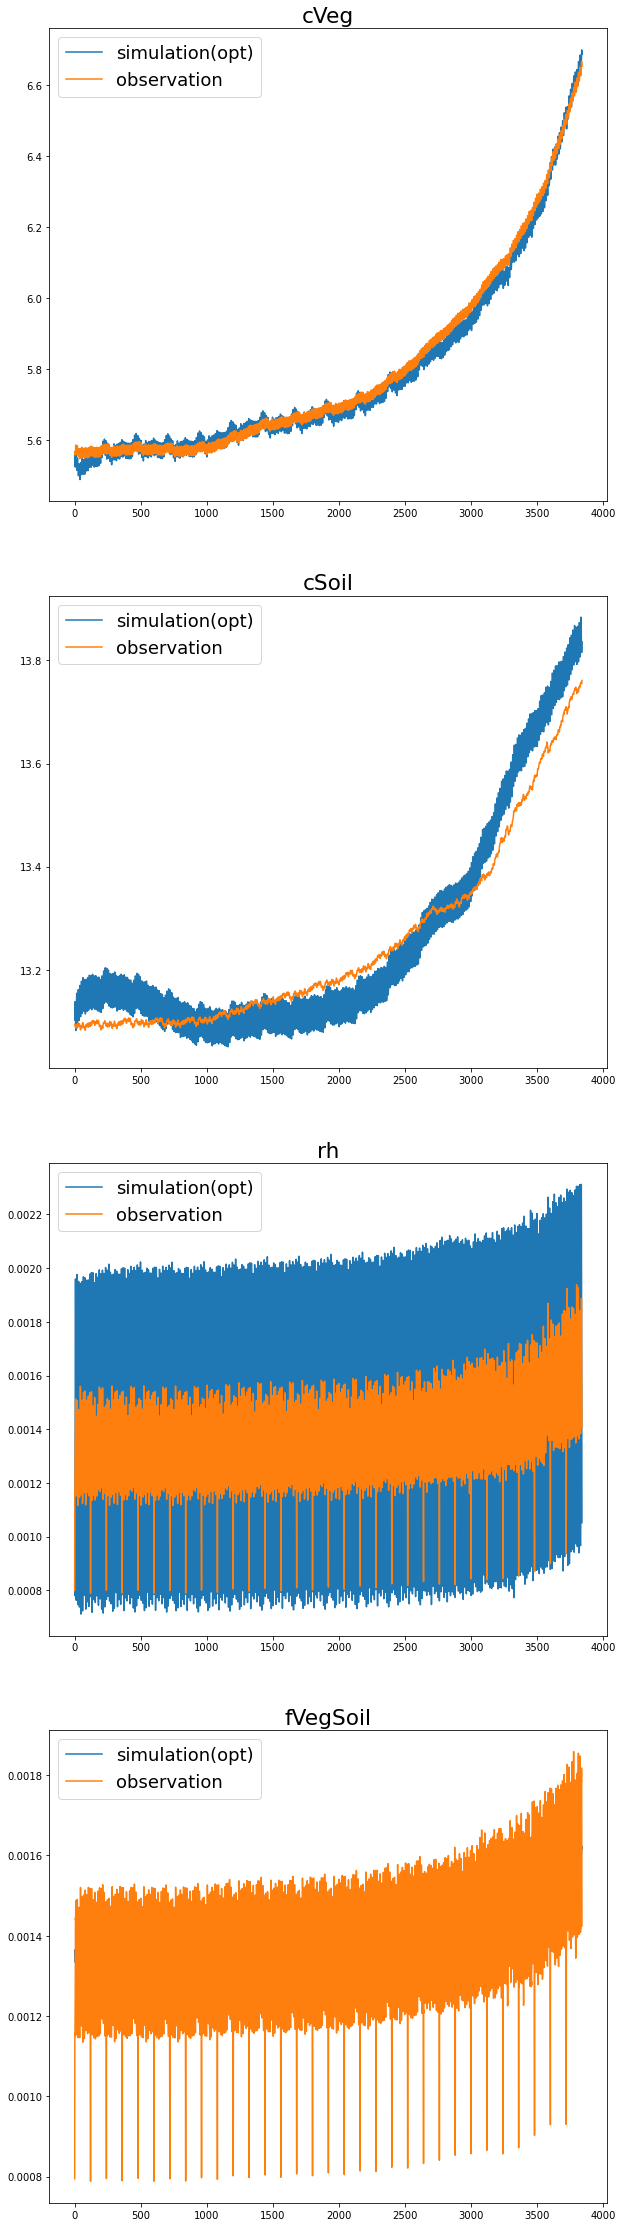

In [25]:
# optimized parameter set (lowest cost function)
par_opt = np.min(
    C_autostep[:, np.where(J_autostep[1] == np.min(J_autostep[1]))].reshape(len(msh.EstimatedParameters._fields), 1),
    axis=1)
epa_opt = msh.EstimatedParameters(*par_opt)
mod_opt = param2res(epa_opt)

n_plots = len(svs)
print("Forward run with optimized parameters (blue) vs TRENDY output (orange)")
fig = plt.figure(figsize=(10, n_plots * 5))
# Plot simulation output for observables
# n_plots=len(svs_cut)
fig = plt.figure(figsize=(10, 10 * n_plots))
axs = fig.subplots(n_plots)
plt.rcParams['font.size'] = 18
for i, name in enumerate(msh.Observables._fields):
    var_simu = mod_opt[i]
    var = svs[i]
    axs[i].plot(range(len(var_simu)), var_simu, label='simulation(opt)')
    axs[i].plot(range(len(var)), var, label='observation')
    axs[i].set_title(name)
    axs[i].legend()

fig.savefig('solutions_opt.pdf')

# save the parameters and cost function values for postprocessing
outputPath = Path(conf_dict["dataPath"])  # save output to data directory (or change it)

import pandas as pd

pd.DataFrame(C_autostep).to_csv(outputPath.joinpath('JULES_da_pars.csv'), sep=',')
pd.DataFrame(J_autostep).to_csv(outputPath.joinpath('JULES_da_cost.csv'), sep=',')
pd.DataFrame(epa_opt).to_csv(outputPath.joinpath('JULES_optimized_pars.csv'), sep=',')
pd.DataFrame(mod_opt).to_csv(outputPath.joinpath('JULES_optimized_solutions.csv'), sep=',')

In [27]:
ta.epa_max
#ta.epa_min
#epa_opt

EstimatedParameters(c_leaf_0=5.579584432067635, c_wood_0=35.337368069761695, c_DPM_0=4.286535867692648, c_RPM_0=425.22435807511073, c_BIO_0=37.721515635695305, beta_leaf=0.5249999999999999, beta_wood=0.44999999999999996, Mw=0.5, Ms=1049.9120793466323, Topt=28.32, Tcons=71.865, r_c_DPM_rh=4.37710437710438, r_c_RPM_rh=0.1733333333333334, r_c_BIO_rh=0.34968253968254, r_c_HUM_rh=0.01174901960784314, r_c_leaf_2_c_DPM=0.0305555555555556, r_c_leaf_2_c_RPM=0.10833333333333339, r_c_wood_2_c_DPM=0.004007285974499081, r_c_wood_2_c_RPM=0.01420765027322404, r_c_root_2_c_DPM=0.0305555555555556, r_c_root_2_c_RPM=0.10833333333333339, r_c_DPM_2_c_BIO=0.567901234567902, r_c_DPM_2_c_HUM=0.666666666666666, r_c_RPM_2_c_BIO=0.0224888888888888, r_c_RPM_2_c_HUM=0.026400000000000003, r_c_BIO_2_c_HUM=0.0471428571428572, r_c_HUM_2_c_BIO=0.001322875816993464)

In [ ]:
import model_specific_helpers_2 as msh
import general_helpers as gh
it_sym_trace = msh.make_traceability_iterator(mvs,dvs,cpa,epa_opt)
ns=1500
StartVectorTrace=gh.make_StartVectorTrace(mvs)
nv=len(StartVectorTrace._fields)
res_trace= np.zeros((ns,nv))
for i in range(ns):
    res_trace[i,:]=it_sym_trace.__next__().reshape(nv)
#res_trace

import matplotlib.pyplot as plt
n=len(mvs.get_StateVariableTuple())
fig=plt.figure(figsize=(20,(n+1)*10), dpi = 400)
axs=fig.subplots(n+1,2)
plt.rcParams['font.size'] = 20

days=list(range(ns))


for i in range(n):
    
    ax = axs[i,0]
    #  the solution
    pos=i
    ax.plot(
        days,
        res_trace[:,i],
        label=StartVectorTrace._fields[pos],
        color='blue'
    )
    # X_p
    pos=i+n
    ax.plot(
        days,
        res_trace[:,pos],
        label=StartVectorTrace._fields[pos],
        color='red'
    )
    # X_c
    pos=i+2*n
    ax.plot(
        days,
        res_trace[:,pos],
        label=StartVectorTrace._fields[pos],
        color='yellow'
    )
    ax.legend()
    
    ax = axs[i,1]
    # RT
    pos=i+3*n
    ax.plot(
        days,
        res_trace[:,pos],
        label=StartVectorTrace._fields[pos],
        color='black'
    )
    ax.legend()
    
axs[n,0].plot(
    days,
    [msh.make_npp_func(dvs)(d) for d in days],
    label='NPP',
    color='green'
)
axs[n,0].legend()
